In [1]:
# library
import pandas as pd
import numpy as np
from datetime import date
import holidays
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split,ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from scipy.stats import ttest_ind
import scipy.stats as stats
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from xgboost import plot_importance, plot_tree
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV

In [2]:
#import dataset
holiday_events = pd.read_csv(r"C:/STUDI INDEPENDEN/Startup Campus/Final Project/Marketing/holidays_events.csv") 
oil = pd.read_csv(r"C:/STUDI INDEPENDEN/Startup Campus/Final Project/Marketing/oil.csv") 
sample_submission = pd.read_csv(r"C:/STUDI INDEPENDEN/Startup Campus/Final Project/Marketing/sample_submission.csv")
stores = pd.read_csv(r"C:/STUDI INDEPENDEN/Startup Campus/Final Project/Marketing/stores.csv")
test = pd.read_csv(r"C:/STUDI INDEPENDEN/Startup Campus/Final Project/Marketing/test.csv")
train = pd.read_csv(r"C:/STUDI INDEPENDEN/Startup Campus/Final Project/Marketing/train.csv")                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
transactions = pd.read_csv(r"C:/STUDI INDEPENDEN/Startup Campus/Final Project/Marketing/transactions.csv")

In [3]:
# merge dataset
A = pd.merge(train, holiday_events, how="left", on="date")
B = pd.merge(A, oil, how="left", on="date")
C = pd.merge(B, stores, how="left", on="store_nbr")
data = pd.merge(C, transactions, how="left", on=["date", "store_nbr"])

In [4]:
# informasi data
print("data shape: ", data.shape)
print("data.head:\n", data.head())

data shape:  (3054348, 17)
data.head:
    id        date  store_nbr      family  sales  onpromotion   type_x  \
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0  Holiday   
1   1  2013-01-01          1   BABY CARE    0.0            0  Holiday   
2   2  2013-01-01          1      BEAUTY    0.0            0  Holiday   
3   3  2013-01-01          1   BEVERAGES    0.0            0  Holiday   
4   4  2013-01-01          1       BOOKS    0.0            0  Holiday   

     locale locale_name         description transferred  dcoilwtico   city  \
0  National     Ecuador  Primer dia del ano       False         NaN  Quito   
1  National     Ecuador  Primer dia del ano       False         NaN  Quito   
2  National     Ecuador  Primer dia del ano       False         NaN  Quito   
3  National     Ecuador  Primer dia del ano       False         NaN  Quito   
4  National     Ecuador  Primer dia del ano       False         NaN  Quito   

       state type_y  cluster  transactions  
0  Pichi

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   int64  
 6   type_x        object 
 7   locale        object 
 8   locale_name   object 
 9   description   object 
 10  transferred   object 
 11  dcoilwtico    float64
 12  city          object 
 13  state         object 
 14  type_y        object 
 15  cluster       int64  
 16  transactions  float64
dtypes: float64(3), int64(4), object(10)
memory usage: 419.5+ MB
None


In [6]:
# mengganti nama kolom
data = data.rename(columns={"type_x":"holiday_type", "type_y":"store_type"})
data.head()

,id,date,store_nbr,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,dcoilwtico,city,state,store_type,cluster,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13,NaN


In [7]:
# missing value
data.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dcoilwtico       955152
city                  0
state                 0
store_type            0
cluster               0
transactions     249117
dtype: int64

In [8]:
# isi missing value
data['holiday_type'] = data['holiday_type'].fillna("Not Detected")
data['locale'] = data['locale'].fillna("Not Detected")
data['locale_name'] = data['locale_name'].fillna("Not Detected")
data['description'] = data['description'].fillna("Not Detected")
data['transferred'] = data['transferred'].fillna("Not Detected")

data['dcoilwtico'] = data['dcoilwtico'].fillna(data['dcoilwtico'].mean())

data['transactions'] = data['transactions'].fillna(0)

In [9]:
# cek kembali missing values
data.isnull().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
city            0
state           0
store_type      0
cluster         0
transactions    0
dtype: int64

In [10]:
# cek data duplikat
print("Apakah terdapat data duplikat?", data.duplicated(keep=False).any())

Apakah terdapat data duplikat? False


In [11]:
# ubah tipe data
data['date'] = pd.to_datetime(data['date'])
data['transactions'] = data['transactions'].astype(int)

# Feature Engineering

In [12]:
data['holiday_type'].value_counts()

Not Detected    2551824
Holiday          304722
Event             99792
Additional        67716
Transfer          16038
Work Day           8910
Bridge             5346
Name: holiday_type, dtype: int64

In [13]:
# mengumpulkan data holidays di ekuador (th 2013 - 2017) menggunakan python holidays
ec_holidays = holidays.EC()
ec_2013 = pd.DataFrame(holidays.EC(years=2013).items(), columns = ['date','name'])
ec_2014 = pd.DataFrame(holidays.EC(years=2014).items(), columns = ['date','name'])
ec_2015 = pd.DataFrame(holidays.EC(years=2015).items(), columns = ['date','name'])
ec_2016 = pd.DataFrame(holidays.EC(years=2016).items(), columns = ['date','name'])
ec_2017 = pd.DataFrame(holidays.EC(years=2017).items(), columns = ['date','name'])

In [14]:
# menggabungkan dataset holidays (th 2013-2017) dengan concat
data_holidays = pd.concat([ec_2013, ec_2014, ec_2015, ec_2016, ec_2017], ignore_index=True)
data_holidays

,date,name
0,2013-01-01,Año Nuevo
1,2013-02-11,Carnaval
2,2013-02-12,Carnaval
3,2013-03-29,Viernes Santo
4,2013-05-01,Día del Trabajo
5,2013-05-24,Batalla de Pichincha
6,2013-08-10,Primer Grito de Independencia
7,2013-10-09,Independencia de Guayaquil
8,2013-11-02,Día de los Difuntos
9,2013-11-03,Independencia de Cuenca


In [15]:
# ubah tipe data
data_holidays['date'] = pd.to_datetime(data_holidays['date'])
data_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    58 non-null     datetime64[ns]
 1   name    58 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 1.0+ KB


In [16]:
# cek sum value dari data holidays
data_holidays['name'].value_counts()

Carnaval                                     10
Año Nuevo                                     5
Viernes Santo                                 5
Día del Trabajo                               5
Batalla de Pichincha                          5
Primer Grito de Independencia                 5
Independencia de Guayaquil                    5
Día de los Difuntos                           5
Independencia de Cuenca                       5
Día de Navidad                                5
Batalla de Pichincha (Observado)              1
Primer Grito de Independencia (Observado)     1
Año Nuevo (Observado)                         1
Name: name, dtype: int64


'Carnaval' = 'Carnaval'
'Año Nuevo'= 'New Year’s Day'
'Viernes Santon'= 'Good Friday'
'Día del Trabajo'= 'International Workers’ Day'
'Batalla de Pichincha'= 'Batalla de Pichincha'
'Primer Grito de Independencia'= 'Declaration of Independence of Quito'
'Independencia de Guayaquil'= 'Independence of Guayaquil'
'Día de los Difuntos'= 'All Souls’ Day'
'Independencia de Cuenca' = 'Independencia de Cuenca'
'Día de Navidad'= 'Christmas Day'
'Batalla de Pichincha (Observado)'= 'Batalla de Pichincha (Observed)'
'Primer Grito de Independencia (Observado)'= 'Declaration of Independence of Quito (Observed)'
'Año Nuevo (Observado)' = 'New Year’s Day (Observed)'

In [17]:
# gabung data holidays ke data
data = pd.merge(data, data_holidays, on="date", how="left")
data.head()

,id,date,store_nbr,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,dcoilwtico,city,state,store_type,cluster,transactions,name
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,68.015874,Quito,Pichincha,D,13,0,Año Nuevo
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,68.015874,Quito,Pichincha,D,13,0,Año Nuevo
2,2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,68.015874,Quito,Pichincha,D,13,0,Año Nuevo
3,3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,68.015874,Quito,Pichincha,D,13,0,Año Nuevo
4,4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,68.015874,Quito,Pichincha,D,13,0,Año Nuevo


In [18]:
# cek kembali missing value pada kolom holidays baru
data.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
holiday_type          0
locale                0
locale_name           0
description           0
transferred           0
dcoilwtico            0
city                  0
state                 0
store_type            0
cluster               0
transactions          0
name            2961684
dtype: int64

In [19]:
# isi missing value dan feature engineering kolom holiday ("Holiday" dan "Not Holiday")
data['name'] = data['name'].fillna("Not Holiday")
data.loc[(data['holiday_type']=="Holiday"), "type_holiday"] = 'Holiday'
data.loc[(data['holiday_type']=="Event"), "type_holiday"] = "Not Holiday"
data.loc[(data['holiday_type']=="Additional"), "type_holiday"] =  "Holiday"
data.loc[(data['holiday_type']=="Transfer"), "type_holiday"] = "Holiday"
data.loc[(data['holiday_type']=="Work Day"), "type_holiday"] = "Holiday"
data.loc[(data['holiday_type']=="Bridge"), "type_holiday"] = "Holiday"

In [20]:
# tambah kolom baru yang berisi deskripsi holidays (bahasa inggris)
data.loc[(data['name']=="Carnaval"), "desc"] = "Carnaval"
data.loc[(data['name']=="Año Nuevo"), "desc"] = "New Year’s Day"
data.loc[(data['name']=="Viernes Santon"), "desc"] = "Good Friday"
data.loc[(data['name']=="Día del Trabajo"), "desc"] = "International Workers’ Day"
data.loc[(data['name']=="Batalla de Pichincha"), "desc"] = "Batalla de Pichincha"
data.loc[(data['name']=="Primer Grito de Independencia"), "desc"] = "Declaration of Independence of Quito"
data.loc[(data['name']=="Independencia de Guayaquil"), "desc"] = "Independence of Guayaquil"
data.loc[(data['name']=="Día de los Difuntos"), "desc"] = "All Souls’ Day"
data.loc[(data['name']=="Independencia de Cuenca"), "desc"] = "Independencia de Cuenca"
data.loc[(data['name']=="Día de Navidad"), "desc"] = "Christmas Day"
data.loc[(data['name']=="Batalla de Pichincha (Observado)"), "desc"] = "Batalla de Pichincha (Observed)"
data.loc[(data['name']=="Primer Grito de Independencia (Observado)"), "desc"] = "Declaration of Independence of Quito (Observed)"
data.loc[(data['name']=="Año Nuevo (Observado)"), "desc"] = "New Year’s Day (Observed)"
data.head()

,id,date,store_nbr,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,dcoilwtico,city,state,store_type,cluster,transactions,name,type_holiday,desc
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,68.015874,Quito,Pichincha,D,13,0,Año Nuevo,Holiday,New Year’s Day
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,68.015874,Quito,Pichincha,D,13,0,Año Nuevo,Holiday,New Year’s Day
2,2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,68.015874,Quito,Pichincha,D,13,0,Año Nuevo,Holiday,New Year’s Day
3,3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,68.015874,Quito,Pichincha,D,13,0,Año Nuevo,Holiday,New Year’s Day
4,4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,68.015874,Quito,Pichincha,D,13,0,Año Nuevo,Holiday,New Year’s Day


In [21]:
# drop kolom yang tidak perlu
data = data.drop(columns=['holiday_type','description','name'])
data.head()

,id,date,store_nbr,family,sales,onpromotion,locale,locale_name,transferred,dcoilwtico,city,state,store_type,cluster,transactions,type_holiday,desc
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,National,Ecuador,False,68.015874,Quito,Pichincha,D,13,0,Holiday,New Year’s Day
1,1,2013-01-01,1,BABY CARE,0.0,0,National,Ecuador,False,68.015874,Quito,Pichincha,D,13,0,Holiday,New Year’s Day
2,2,2013-01-01,1,BEAUTY,0.0,0,National,Ecuador,False,68.015874,Quito,Pichincha,D,13,0,Holiday,New Year’s Day
3,3,2013-01-01,1,BEVERAGES,0.0,0,National,Ecuador,False,68.015874,Quito,Pichincha,D,13,0,Holiday,New Year’s Day
4,4,2013-01-01,1,BOOKS,0.0,0,National,Ecuador,False,68.015874,Quito,Pichincha,D,13,0,Holiday,New Year’s Day


In [22]:
# Buat kolom baru sebagai kolom penjualan (Total Sales)
data['total_sales'] = (data['dcoilwtico'] * data['transactions'])
# Before - After gempa di Ecuador
data.loc[(data['date'] < '2016-04-16'), 'Earthquake'] = 'Before Earthquake'
data.loc[(data['date'] >= '2016-04-16'), 'Earthquake'] = 'After Earthquake'

In [23]:
data.head()

,id,date,store_nbr,family,sales,onpromotion,locale,locale_name,transferred,dcoilwtico,city,state,store_type,cluster,transactions,type_holiday,desc,total_sales,Earthquake
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,National,Ecuador,False,68.015874,Quito,Pichincha,D,13,0,Holiday,New Year’s Day,0.0,Before Earthquake
1,1,2013-01-01,1,BABY CARE,0.0,0,National,Ecuador,False,68.015874,Quito,Pichincha,D,13,0,Holiday,New Year’s Day,0.0,Before Earthquake
2,2,2013-01-01,1,BEAUTY,0.0,0,National,Ecuador,False,68.015874,Quito,Pichincha,D,13,0,Holiday,New Year’s Day,0.0,Before Earthquake
3,3,2013-01-01,1,BEVERAGES,0.0,0,National,Ecuador,False,68.015874,Quito,Pichincha,D,13,0,Holiday,New Year’s Day,0.0,Before Earthquake
4,4,2013-01-01,1,BOOKS,0.0,0,National,Ecuador,False,68.015874,Quito,Pichincha,D,13,0,Holiday,New Year’s Day,0.0,Before Earthquake


In [24]:
data.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
locale                0
locale_name           0
transferred           0
dcoilwtico            0
city                  0
state                 0
store_type            0
cluster               0
transactions          0
type_holiday    2551824
desc            2972376
total_sales           0
Earthquake            0
dtype: int64

In [25]:
data['type_holiday'] = data['type_holiday'].fillna("Not Holiday")
data['desc'] = data['desc'].fillna("Not Holiday")

In [26]:
#buat kolom baru yaitu tahun, bulan, dan minggu
data['Month'] = data['date'].apply(lambda x: pd.to_datetime(x).month)
data['Year'] = data['date'].apply(lambda x: pd.to_datetime(x).year)
data['week'] = data['date'].apply(lambda x: pd.to_datetime(x).week)

In [27]:
data.head()

,id,date,store_nbr,family,sales,onpromotion,locale,locale_name,transferred,dcoilwtico,...,store_type,cluster,transactions,type_holiday,desc,total_sales,Earthquake,Month,Year,week
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,National,Ecuador,False,68.015874,...,D,13,0,Holiday,New Year’s Day,0.0,Before Earthquake,1,2013,1
1,1,2013-01-01,1,BABY CARE,0.0,0,National,Ecuador,False,68.015874,...,D,13,0,Holiday,New Year’s Day,0.0,Before Earthquake,1,2013,1
2,2,2013-01-01,1,BEAUTY,0.0,0,National,Ecuador,False,68.015874,...,D,13,0,Holiday,New Year’s Day,0.0,Before Earthquake,1,2013,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,National,Ecuador,False,68.015874,...,D,13,0,Holiday,New Year’s Day,0.0,Before Earthquake,1,2013,1
4,4,2013-01-01,1,BOOKS,0.0,0,National,Ecuador,False,68.015874,...,D,13,0,Holiday,New Year’s Day,0.0,Before Earthquake,1,2013,1


In [28]:
data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'locale',
       'locale_name', 'transferred', 'dcoilwtico', 'city', 'state',
       'store_type', 'cluster', 'transactions', 'type_holiday', 'desc',
       'total_sales', 'Earthquake', 'Month', 'Year', 'week'],
      dtype='object')

In [29]:
data.shape

(3054348, 22)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   locale        object        
 7   locale_name   object        
 8   transferred   object        
 9   dcoilwtico    float64       
 10  city          object        
 11  state         object        
 12  store_type    object        
 13  cluster       int64         
 14  transactions  int32         
 15  type_holiday  object        
 16  desc          object        
 17  total_sales   float64       
 18  Earthquake    object        
 19  Month         int64         
 20  Year          int64         
 21  week          int64         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(7), object(10)
m

# EDA Business

# 1. Apakah terdapat tren penjualan yang terlihat pada periode waktu tertentu, misalnya mingguan atau bulanan?


#### Tren penjualan berdasarkan mingguan 

In [31]:
min_date = data['date'].min()
max_date = data['date'].max()

num_weeks = (max_date - min_date) // timedelta(weeks=1)
if num_weeks > 0:
    print("Ada", num_weeks, "minggu antara", min_date, "dan", max_date)
else:
    print("Tidak ada minggu antara", min_date, "dan", max_date)


Ada 241 minggu antara 2013-01-01 00:00:00 dan 2017-08-15 00:00:00


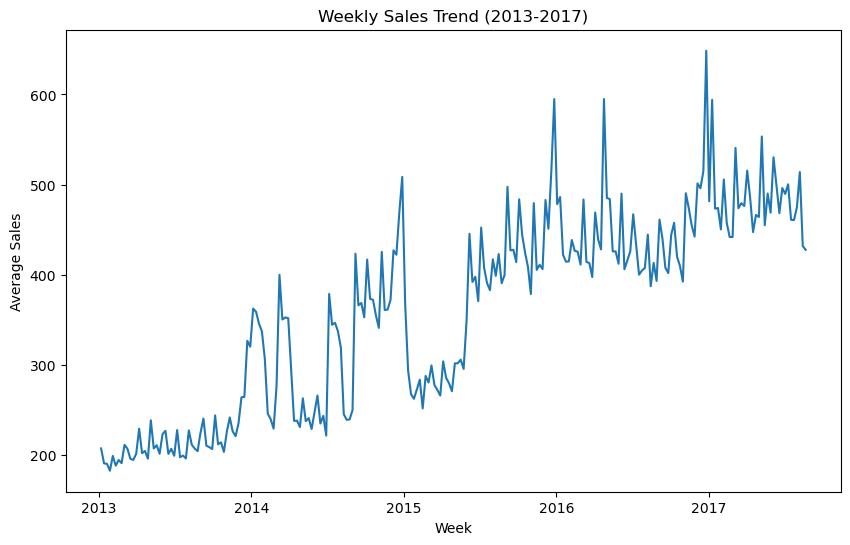

In [32]:
# Mengambil subset data berdasarkan rentang waktu
subset_data = data[(data['date'] >= '2013-01-01') & (data['date'] <= '2017-08-15')]

# Mengelompokkan data berdasarkan minggu dan menghitung rata-rata penjualan
weekly_sales = subset_data.groupby(pd.Grouper(key='date', freq='W'))['sales'].mean()

# Memplot grafik garis penjualan mingguan
plt.figure(figsize=(10, 6))
sns.lineplot(data=weekly_sales)
plt.title('Weekly Sales Trend (2013-2017)')
plt.xlabel('Week')
plt.ylabel('Average Sales')
plt.show()

In [33]:
high_weeks = []

high_thresholdw = weekly_sales.quantile(0.75)
low_thresholdw = weekly_sales.quantile(0.25)

for week, sales in weekly_sales.items():
    if sales >= high_thresholdw:
        high_weeks.append((week.year, week.month, week.week))

print("Minggu dengan penjualan tinggi:")
for year, month, week in high_weeks:
    print("Tahun:", year, "Bulan:", month, "Minggu:", week)

Minggu dengan penjualan tinggi:
Tahun: 2014 Bulan: 12 Minggu: 51
Tahun: 2014 Bulan: 12 Minggu: 52
Tahun: 2015 Bulan: 6 Minggu: 23
Tahun: 2015 Bulan: 7 Minggu: 27
Tahun: 2015 Bulan: 9 Minggu: 36
Tahun: 2015 Bulan: 10 Minggu: 40
Tahun: 2015 Bulan: 10 Minggu: 41
Tahun: 2015 Bulan: 11 Minggu: 45
Tahun: 2015 Bulan: 12 Minggu: 49
Tahun: 2015 Bulan: 12 Minggu: 50
Tahun: 2015 Bulan: 12 Minggu: 51
Tahun: 2015 Bulan: 12 Minggu: 52
Tahun: 2016 Bulan: 1 Minggu: 53
Tahun: 2016 Bulan: 1 Minggu: 1
Tahun: 2016 Bulan: 3 Minggu: 9
Tahun: 2016 Bulan: 4 Minggu: 13
Tahun: 2016 Bulan: 4 Minggu: 16
Tahun: 2016 Bulan: 5 Minggu: 17
Tahun: 2016 Bulan: 5 Minggu: 18
Tahun: 2016 Bulan: 6 Minggu: 22
Tahun: 2016 Bulan: 7 Minggu: 26
Tahun: 2016 Bulan: 8 Minggu: 31
Tahun: 2016 Bulan: 9 Minggu: 35
Tahun: 2016 Bulan: 10 Minggu: 40
Tahun: 2016 Bulan: 11 Minggu: 44
Tahun: 2016 Bulan: 11 Minggu: 45
Tahun: 2016 Bulan: 11 Minggu: 46
Tahun: 2016 Bulan: 12 Minggu: 48
Tahun: 2016 Bulan: 12 Minggu: 49
Tahun: 2016 Bulan: 12 Mingg

#### Tren penjualan berdasarkan bulanan 

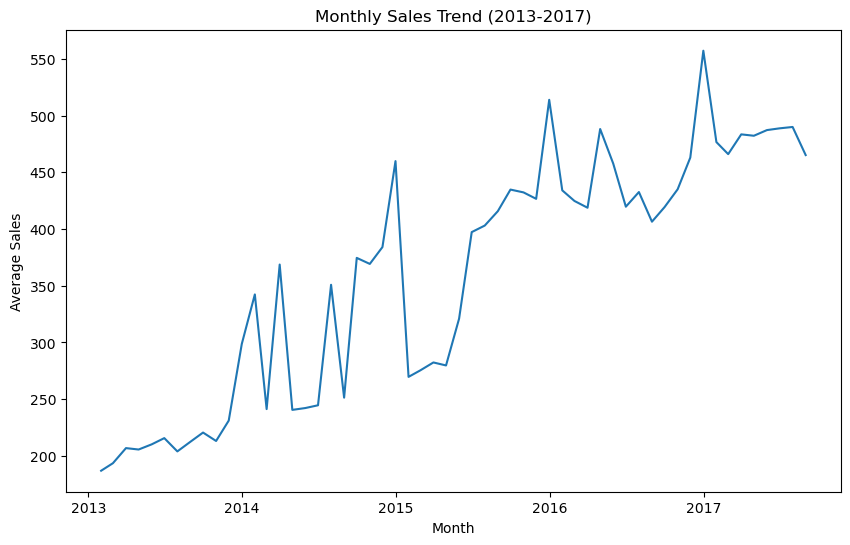

In [34]:
# Mengambil subset data berdasarkan rentang waktu
subset_data = data[(data['date'] >= '2013-01-01') & (data['date'] <= '2017-08-15')]

# Mengelompokkan data berdasarkan bulan dan menghitung rata-rata penjualan
monthly_sales = subset_data.groupby(pd.Grouper(key='date', freq='M'))['sales'].mean()

# Memplot grafik garis penjualan bulanan
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_sales)
plt.title('Monthly Sales Trend (2013-2017)')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.show()

In [35]:
high_months = []

high_thresholdm = monthly_sales.quantile(0.75)
low_thresholdm = monthly_sales.quantile(0.25)

for month, sales in monthly_sales.items():
    if sales >= high_thresholdm:
        high_months.append((month.year, month.month))

print("Bulan dengan penjualan tinggi:")
for year, month in high_months:
    print("Tahun:", year, "Bulan:", month)

Bulan dengan penjualan tinggi:
Tahun: 2014 Bulan: 12
Tahun: 2015 Bulan: 12
Tahun: 2016 Bulan: 4
Tahun: 2016 Bulan: 5
Tahun: 2016 Bulan: 11
Tahun: 2016 Bulan: 12
Tahun: 2017 Bulan: 1
Tahun: 2017 Bulan: 2
Tahun: 2017 Bulan: 3
Tahun: 2017 Bulan: 4
Tahun: 2017 Bulan: 5
Tahun: 2017 Bulan: 6
Tahun: 2017 Bulan: 7
Tahun: 2017 Bulan: 8


In [36]:
low_months = []

for month, sales in monthly_sales.items():
    if sales <= low_thresholdm:
        low_months.append((month.year, month.month))

print("Bulan dengan penjualan rendah:")
for year, month in low_months:
    print("Tahun:", year, "Bulan:", month)

Bulan dengan penjualan rendah:
Tahun: 2013 Bulan: 1
Tahun: 2013 Bulan: 2
Tahun: 2013 Bulan: 3
Tahun: 2013 Bulan: 4
Tahun: 2013 Bulan: 5
Tahun: 2013 Bulan: 6
Tahun: 2013 Bulan: 7
Tahun: 2013 Bulan: 8
Tahun: 2013 Bulan: 9
Tahun: 2013 Bulan: 10
Tahun: 2013 Bulan: 11
Tahun: 2014 Bulan: 2
Tahun: 2014 Bulan: 4
Tahun: 2014 Bulan: 5


#### Tren penjualan berdasarkan tahunan 

In [37]:
print(data['date'].min())  # Tanggal minimum dalam dataset
print(data['date'].max())  # Tanggal maksimum dalam dataset

2013-01-01 00:00:00
2017-08-15 00:00:00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


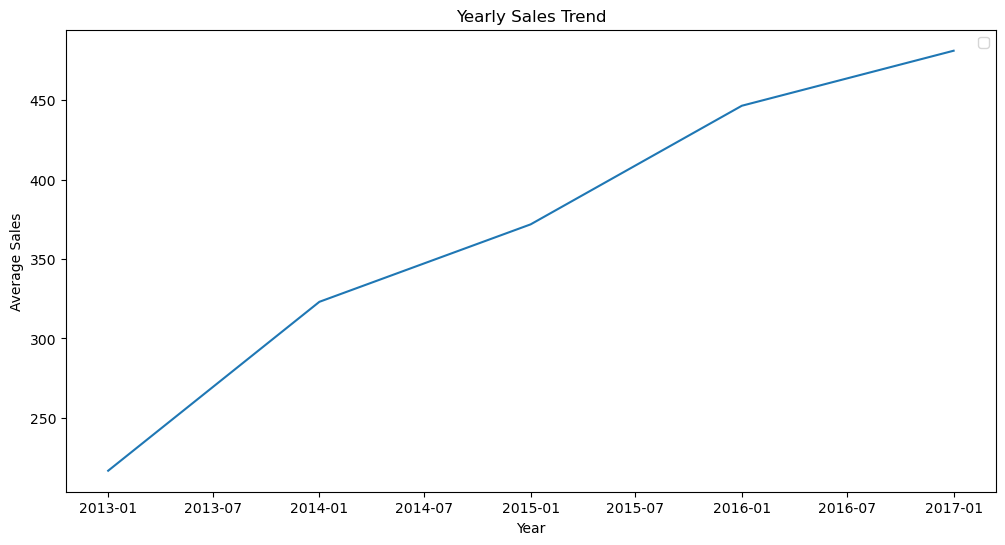

In [38]:
subset_data = data[(data['date'] >= '2013-01-01') & (data['date'] <= '2017-08-15')]

yearly_sales = data.groupby(pd.Grouper(key='date', freq='YS'))['sales'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_sales)
plt.title('Yearly Sales Trend')
plt.xlabel('Year')
plt.ylabel('Average Sales')
plt.legend()
plt.show()

In [39]:
high_years = []
low_years = []

high_thresholdy = yearly_sales.quantile(0.75)
low_thresholdy = yearly_sales.quantile(0.25)

for week, sales in weekly_sales.items():
    year = week.year
    if sales >= high_thresholdy and year not in high_years:
        high_years.append(year)
    elif sales <= low_thresholdy and year not in low_years:
        low_years.append(year)

print("Tahun dengan nilai penjualan tinggi:", high_years)
print("Tahun dengan nilai penjualan rendah:", low_years)

Tahun dengan nilai penjualan tinggi: [2014, 2015, 2016, 2017]
Tahun dengan nilai penjualan rendah: [2013, 2014, 2015]


# 2. Apakah ada produk yang lebih populer di satu toko daripada yang lain?

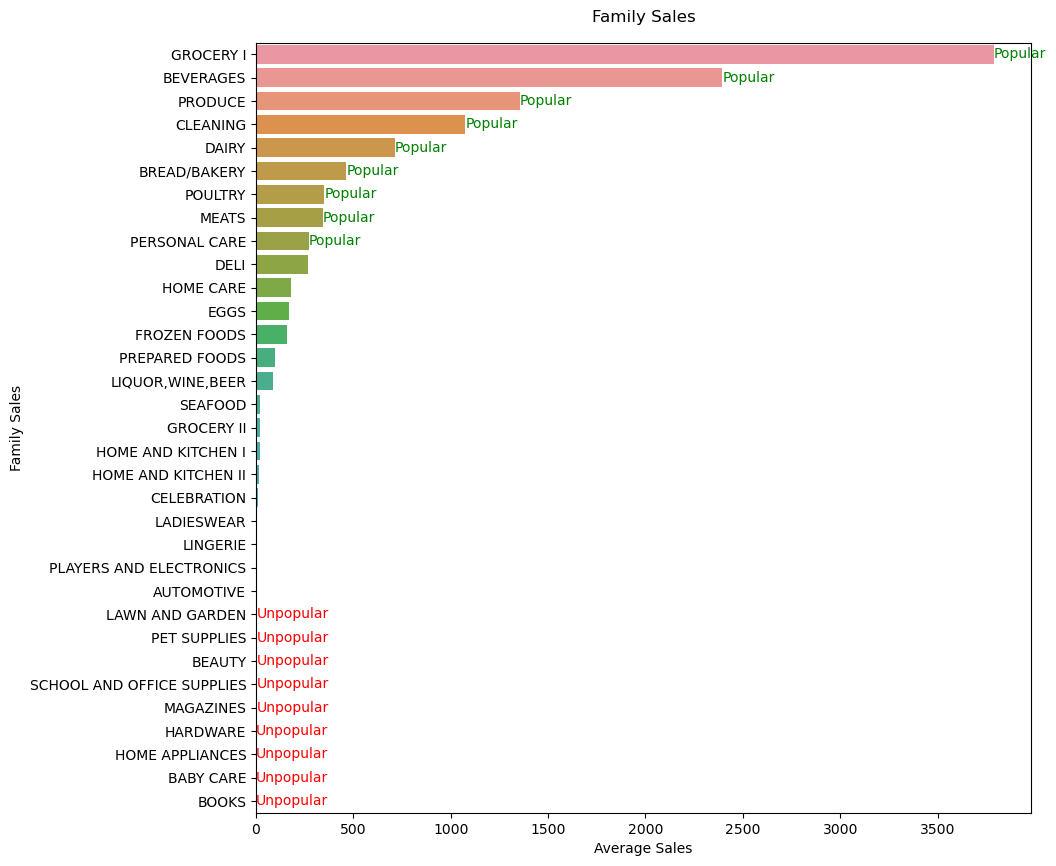

In [40]:
product_sales = data.groupby("family").sales.mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10, 10))
sns.barplot(y='family', x='sales', data=product_sales)
plt.title("Family Sales", pad=15)

# Menentukan ambang batas produk populer dan tidak populer
threshold_popular = product_sales['sales'].quantile(0.75)
threshold_unpopular = product_sales['sales'].quantile(0.25)


# Memberi tanda pada produk populer dan tidak populer
for index, row in product_sales.iterrows():
    if row['sales'] >= threshold_popular:
        plt.text(row['sales'], index, "Popular", color='green', ha='left', va='center')
    elif row['sales'] <= threshold_unpopular:
        plt.text(row['sales'], index, "Unpopular", color='red', ha='left', va='center')


plt.xlabel("Average Sales")
plt.ylabel("Family Sales")
plt.show()

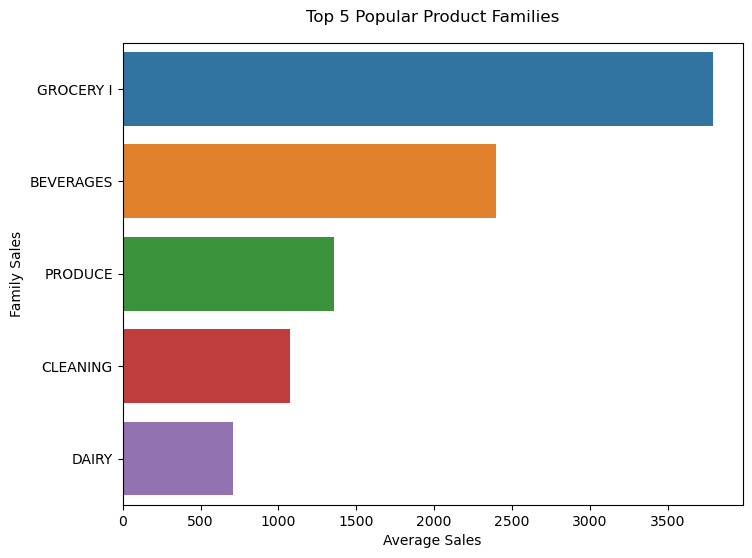

In [41]:
# Mengambil lima produk popular
product_sales = data.groupby("family").sales.mean().sort_values(ascending=False).reset_index()

popular_products = product_sales.head(5)

plt.figure(figsize=(8, 6))
sns.barplot(y='family', x='sales', data=popular_products)
plt.title("Top 5 Popular Product Families", pad=15)

plt.xlabel("Average Sales")
plt.ylabel("Family Sales")
plt.show()

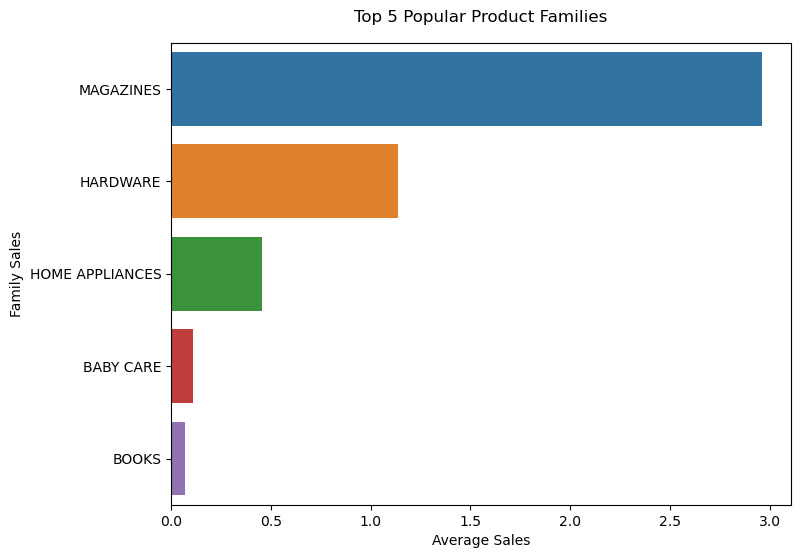

In [42]:
# Mengambil lima produk unpopular
product_sales = data.groupby("family").sales.mean().sort_values(ascending=False).reset_index()

popular_products = product_sales.tail(5)

plt.figure(figsize=(8, 6))
sns.barplot(y='family', x='sales', data=popular_products)
plt.title("Top 5 Popular Product Families", pad=15)

plt.xlabel("Average Sales")
plt.ylabel("Family Sales")
plt.show()

# 3. Apakah promosi berpengaruh signifikan terhadap penjualan?

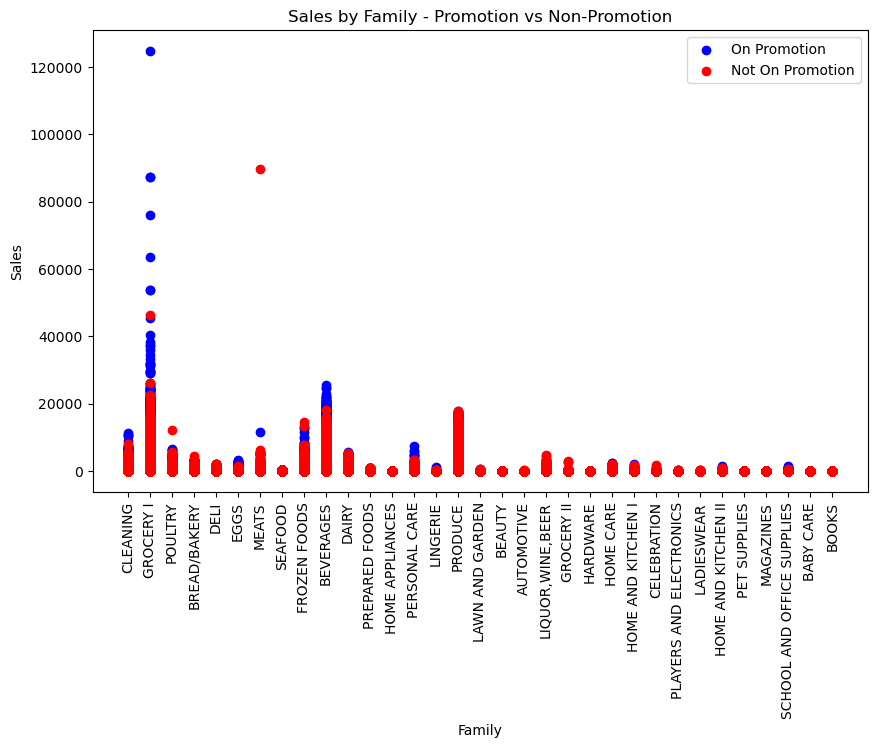

In [43]:
# Filter data hanya untuk saat ada promosi dan tidak ada promosi
filtered_data_promotion = data[data['onpromotion'] != 0]
filtered_data_non_promotion = data[data['onpromotion'] == 0]

# Membuat scatter plot untuk promosi dan tidak promosi
plt.scatter(filtered_data_promotion['family'], filtered_data_promotion['sales'], c='blue', label='On Promotion')
plt.scatter(filtered_data_non_promotion['family'], filtered_data_non_promotion['sales'], c='red', label='Not On Promotion')

plt.xlabel('Family')
plt.ylabel('Sales')
plt.title('Sales by Family - Promotion vs Non-Promotion')
plt.legend()

# Mengatur ukuran dan label sumbu x
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.xticks(rotation=90)

# Menampilkan plot
plt.show()

In [44]:
onpromotion = data['onpromotion']
sales = data['sales']

# Menghitung coefficient antara promosi dengan penjualan
cf = onpromotion.corr(sales)

print('Correlation coefficient antara promosi dan penjualan:', cf)

Correlation coefficient antara promosi dan penjualan: 0.4282410665192631


Hasil koefisien korelasi antara **onpromotion** dan **sales** sebesar 0.4282 menunjukkan bahwa terdapat **korelasi positif** antara kedua variabel tersebut. 

Dalam hal ini, semakin tinggi nilai 'onpromotion', maka kemungkinan semakin tinggi nilai 'sales'. Jadi, dapat dikatakan bahwa adanya promosi mempengaruhi peningkatan penjualan pada produk tersebut. 

Namun, nilai koefisien korelasi ini tidak terlalu tinggi, sehingga kemungkinan faktor lain seperti harga, persaingan, atau kebijakan toko juga dapat mempengaruhi penjualan produk.

# 4. Bagaimana pengaruh hari libur terhadap penjualan? Apakah terdapat perbedaan penjualan pada weekend dan weekday?

In [45]:
# Filter data by holiday and non-holiday
holiday_sales = data[data['type_holiday'] == 'Holiday']['sales']
non_holiday_sales = data[data['type_holiday'] == 'Not Holiday']['sales']

# Perform t-test
t_stat, p_val = ttest_ind(holiday_sales, non_holiday_sales, equal_var=False)

if p_val < 0.05:
    print("Penjualan pada hari libur berbeda secara signifikan dengan penjualan pada hari biasa.")
else:
    print("Tidak ada perbedaan yang signifikan antara penjualan pada hari libur dan hari biasa.")

Penjualan pada hari libur berbeda secara signifikan dengan penjualan pada hari biasa.


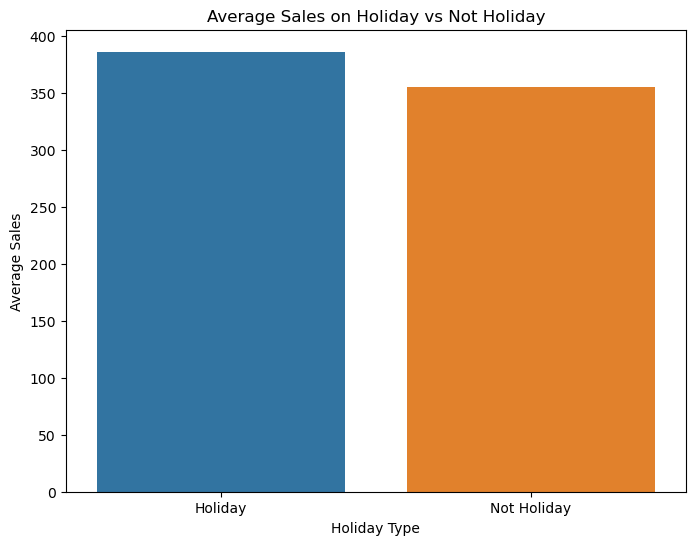

In [46]:
sales_by_holiday = data.groupby('type_holiday')['sales'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='type_holiday', y='sales', data=sales_by_holiday)
plt.title('Average Sales on Holiday vs Not Holiday')
plt.xlabel('Holiday Type')
plt.ylabel('Average Sales')

plt.show()


In [47]:
# Filter data by weekend and weekday holiday
weekend_holiday_sales = data[data['date'].dt.weekday >= 5]['sales'] #weekend

weekday_holiday_sales = data[data['date'].dt.weekday < 5]['sales'] #weekday

# Perform t-test
t_stat, p_val = ttest_ind(weekend_holiday_sales, weekday_holiday_sales, equal_var=False)

if p_val < 0.05:
    print("Penjualan pada weekend berbeda secara signifikan dengan penjualan pada weekday.")
else:
    print("Tidak ada perbedaan yang signifikan antara penjualan weekend dan weekday.")

Penjualan pada weekend berbeda secara signifikan dengan penjualan pada weekday.


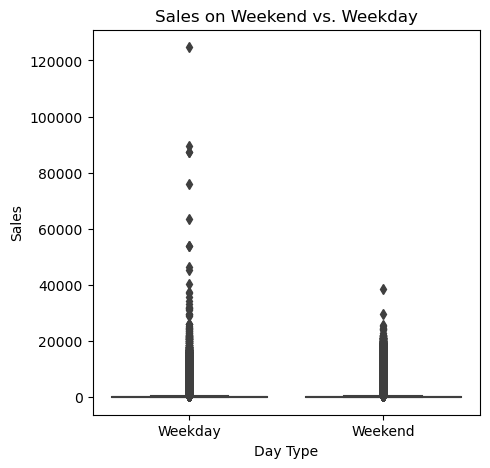

In [48]:
plt.figure(figsize=(5, 5))
sns.boxplot(x=data['date'].dt.weekday.map({0: 'Weekday', 1: 'Weekday', 2: 'Weekday', 3: 'Weekday', 4: 'Weekday', 5: 'Weekend', 6: 'Weekend'}),
            y=data['sales'])
plt.title('Sales on Weekend vs. Weekday')
plt.xlabel('Day Type')
plt.ylabel('Sales')
plt.show()

# 5. Apakah terdapat trend/pola dari pengaruh gempa bumi terhadap penjualan? Apakah penjualan berkurang setelah gempa bumi terjadi?

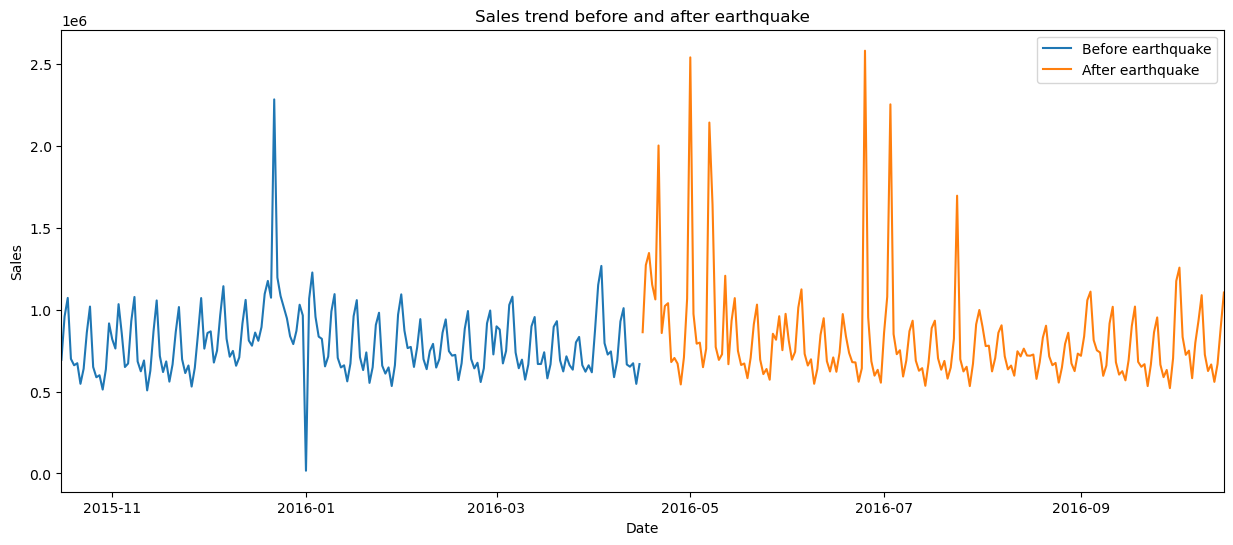

In [49]:
plt.figure(figsize=(15, 6))
before_eq = data[(data['Earthquake'] == 'Before Earthquake') & (data['date'] >= pd.to_datetime('2015-10-16')) & (data['date'] <= pd.to_datetime('2016-10-16'))]
after_eq = data[(data['Earthquake'] == 'After Earthquake') & (data['date'] >= pd.to_datetime('2015-10-16')) & (data['date'] <= pd.to_datetime('2016-10-16'))]

sales_before = before_eq.groupby('date')['sales'].sum()
sales_after = after_eq.groupby('date')['sales'].sum()

plt.plot(sales_before.index, sales_before.values, label='Before earthquake')
plt.plot(sales_after.index, sales_after.values, label='After earthquake')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales trend before and after earthquake')
plt.legend()

plt.xlim(pd.to_datetime('2015-10-16'), pd.to_datetime('2016-10-16'))

plt.show()

Total penjualan satu minggu setelah gempa bumi pada tahun 2016: 9575753.2712837
Total penjualan satu minggu sebelum gempa bumi pada tahun 2016: 5140867.115212


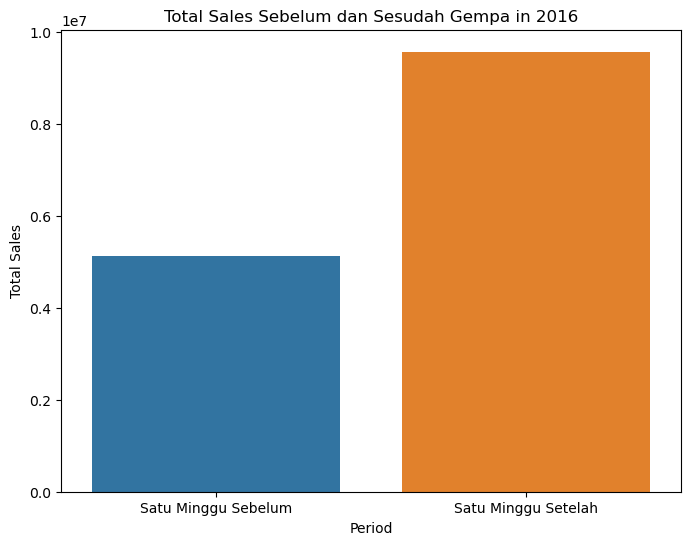

In [50]:
# Menyaring data selama satu minggu setelah gempa bumi pada tahun 2016
start_date_after = pd.to_datetime('2016-04-16')
end_date_after = start_date_after + pd.DateOffset(weeks=1)
sales_after_eq = data[(data['date'] >= start_date_after) & (data['date'] <= end_date_after)]['sales'].sum()

# Filter data selama satu minggu sebelum gempa bumi pada tahun 2016
end_date_before = pd.to_datetime('2016-04-16')
start_date_before = end_date_before - pd.DateOffset(weeks=1)
sales_before_eq = data[(data['date'] >= start_date_before) & (data['date'] < end_date_before)]['sales'].sum()

# Mencetak total penjualan untuk setiap periode
print("Total penjualan satu minggu setelah gempa bumi pada tahun 2016:", sales_after_eq)
print("Total penjualan satu minggu sebelum gempa bumi pada tahun 2016:", sales_before_eq)

# Membuat bar plot menggunakan Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=['Satu Minggu Sebelum', 'Satu Minggu Setelah'], y=[sales_before_eq, sales_after_eq])
plt.xlabel('Period')
plt.ylabel('Total Sales')
plt.title('Total Sales Sebelum dan Sesudah Gempa in 2016')
plt.show()

# 6. Apakah ada perbedaan dalam tren penjualan antara jenis produk yang berbeda?

In [51]:
# Kelompokkan data penjualan berdasarkan kategori produk
grouped_data = data.groupby('family')['sales'].apply(list)

# Lakukan Kruskal-Wallis test
h_stat, p_val = stats.kruskal(*grouped_data)

# Memeriksa p-value
if p_val < 0.05:
    print("Ada perbedaan yang signifikan dalam tren penjualan antara jenis produk yang berbeda.")
else:
    print("Tidak ada perbedaan yang signifikan dalam tren penjualan antara jenis produk yang berbeda.")

Ada perbedaan yang signifikan dalam tren penjualan antara jenis produk yang berbeda.


In [52]:
# Convert date column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Extract year from the date
data['year'] = data['date'].dt.year

# Group the data by store, year, and family, and calculate the mean sales
store_product_sales = data.groupby(['store_nbr', 'year', 'family'])['sales'].mean().reset_index()

# Create the Plotly figure
fig = px.bar(store_product_sales, x='sales', y='family', color='store_nbr',
             facet_col='year', facet_col_wrap=3, orientation='h')

# Update layout and labels
fig.update_layout(
    title='Product Sales by Store and Family (Yearly)',
    xaxis_title='Average Sales',
    yaxis_title='Family',
    legend_title='Store'
)

# Show the plot
fig.show()

# 7. Apakah ada korelasi antara harga minyak dan penjualan? Apakah perubahan harga minyak mempengaruhi pola penjualan?

In [53]:
# Menghitung correlation coefficient
corr_coef = np.corrcoef(data['dcoilwtico'], data['sales'])[0][1]
print(f"Correlation Coefficient: {corr_coef}")

Correlation Coefficient: -0.057869503832684084


Text(0, 0.5, 'Amount')

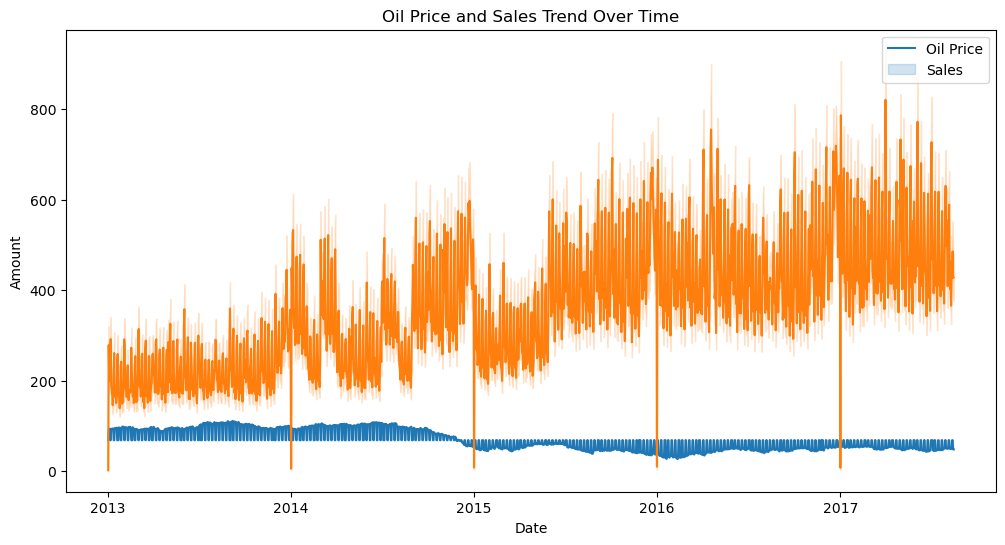

In [54]:
# Buat plot garis untuk memvisualisasikan tren harga dan penjualan minyak dari waktu ke waktu
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='date', y='dcoilwtico')
sns.lineplot(data=data, x='date', y='sales')
plt.legend(['Oil Price', 'Sales'])
plt.title('Oil Price and Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Amount')

Koefisien korelasi antara harga minyak dan penjualan memiliki nilai negatif yang artinya jika harga minyak mengalami peningkatan, maka penjualan akan mengalami penurunan, begitu sebaliknya. Namun, ketika harga minyak turun, penjualan tidak selalu naik. Korelasi ini dapat diartikan bahwa ada faktor lain yang lebih kuat mempengaruhi penjualan dibandingkan dengan harga minyak. Nilai koefisien korelasi yang didapat adalah 0.0579 yang bermakna bahwa harga minyak dan penjualan memiliki keeratan hubungan yang kecil (lemah). Sehingga kamu memutuskan untuk drop kolom 'dcoilwtico' saat data preprocessing.

# 8. Apakah terdapat perbedaan tren penjualan antara toko di kota yang berbeda? Apakah ada perbedaan antara toko di negara bagian yang berbeda?

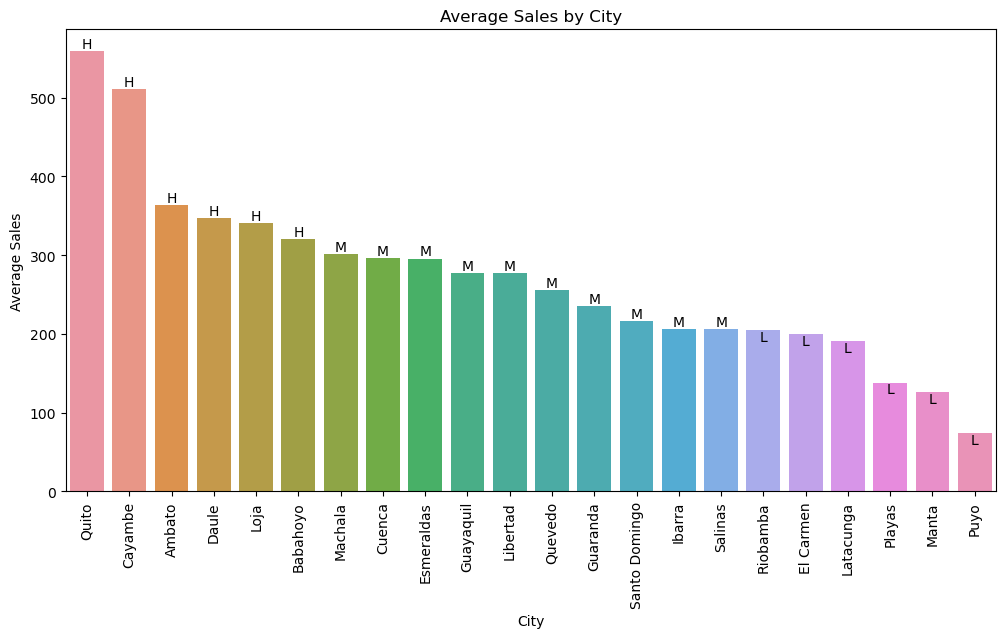

In [55]:
# Menghitung rata-rata penjualan untuk setiap kota
sales_by_city = data.groupby('city')['sales'].mean().sort_values(ascending=False)

# Plot rata-rata penjualan per kota
plt.figure(figsize=(12, 6))
sns.barplot(x=sales_by_city.index, y=sales_by_city.values)
plt.title('Average Sales by City')
plt.xlabel('City')
plt.ylabel('Average Sales')

# Menandai kota dengan penjualan tinggi, sedang, dan rendah
high_threshold = sales_by_city.quantile(0.75)
low_threshold = sales_by_city.quantile(0.25)

for i, value in enumerate(sales_by_city):
    if value >= high_threshold:
        plt.text(i, value, 'H', ha='center', va='bottom')
    elif value <= low_threshold:
        plt.text(i, value, 'L', ha='center', va='top')
    else:
        plt.text(i, value, 'M', ha='center', va='bottom')

plt.xticks(rotation=90)
plt.show()

NOTE:

H = High sales, M = Medium sales, L = Low sales

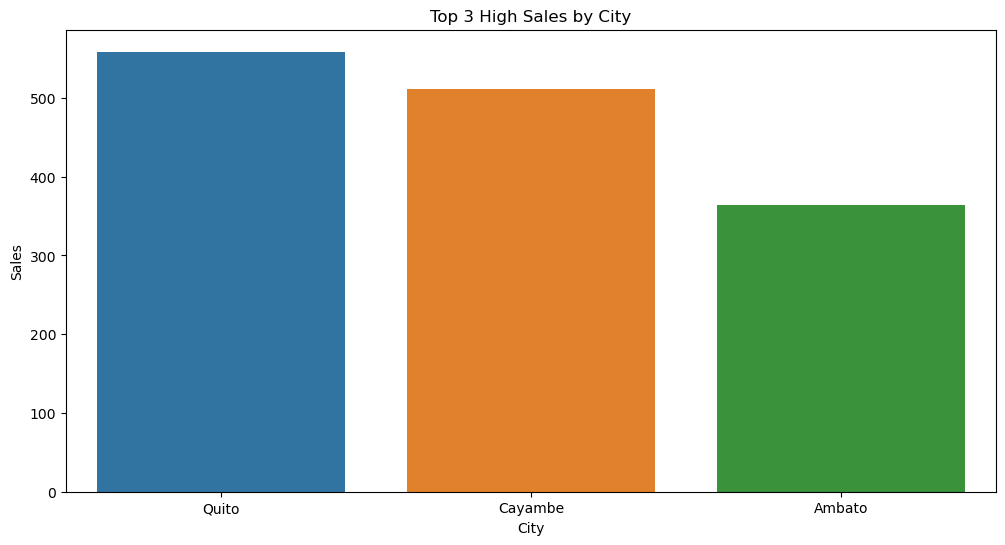

In [56]:
# High Sales tiap kota
# Medium Sales tiap kota
# Menghitung rata-rata penjualan untuk setiap kota
sales_by_city = data.groupby('city')['sales'].mean().sort_values(ascending=False).head(3)

# Plot rata-rata penjualan per kota
plt.figure(figsize=(12, 6))
sns.barplot(x=sales_by_city.index, y=sales_by_city.values)
plt.title('Top 3 High Sales by City')
plt.xlabel('City')
plt.ylabel('Sales')
plt.show()

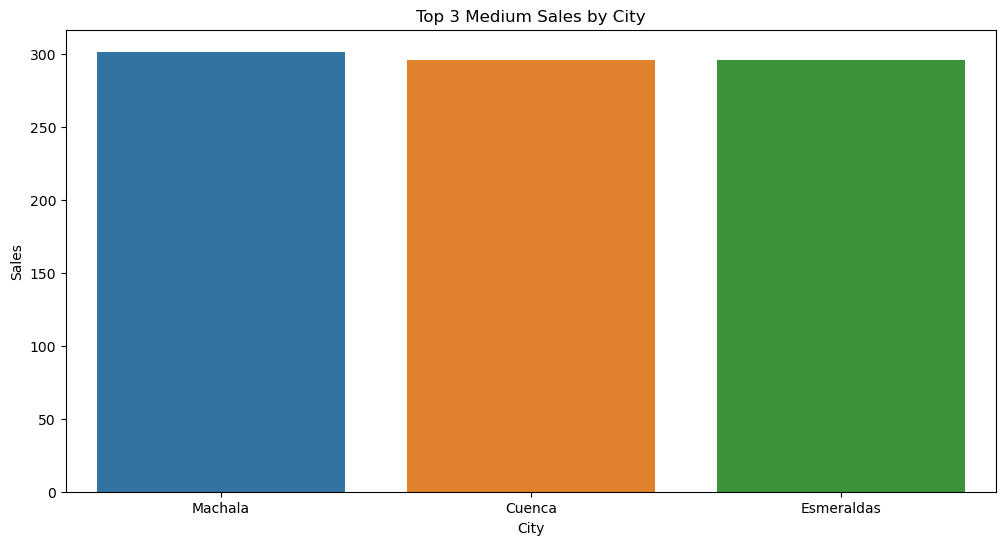

In [57]:
# Medium Sales tiap kota
# Menghitung rata-rata penjualan untuk setiap kota
sales_by_city = data.groupby('city')['sales'].mean().sort_values(ascending=False).iloc[6:9]

# Plot rata-rata penjualan per kota
plt.figure(figsize=(12, 6))
sns.barplot(x=sales_by_city.index, y=sales_by_city.values)
plt.title('Top 3 Medium Sales by City')
plt.xlabel('City')
plt.ylabel('Sales')
plt.show()

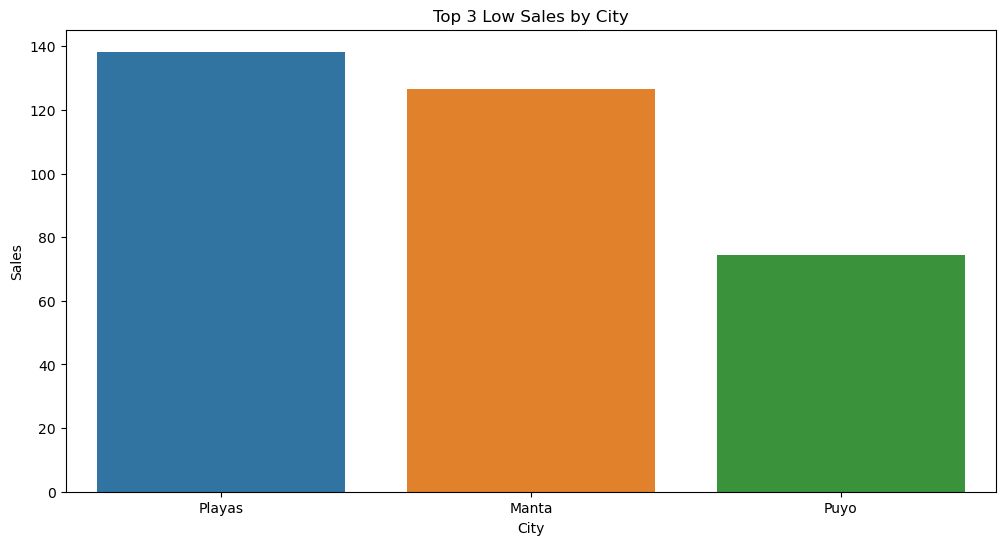

In [58]:
# Low Sales tiap kota
# Menghitung rata-rata penjualan untuk setiap kota
sales_by_city = data.groupby('city')['sales'].mean().sort_values(ascending=False).tail(3)

# Plot rata-rata penjualan per kota
plt.figure(figsize=(12, 6))
sns.barplot(x=sales_by_city.index, y=sales_by_city.values)
plt.title('Top 3 Low Sales by City')
plt.xlabel('City')
plt.ylabel('Sales')
plt.show()

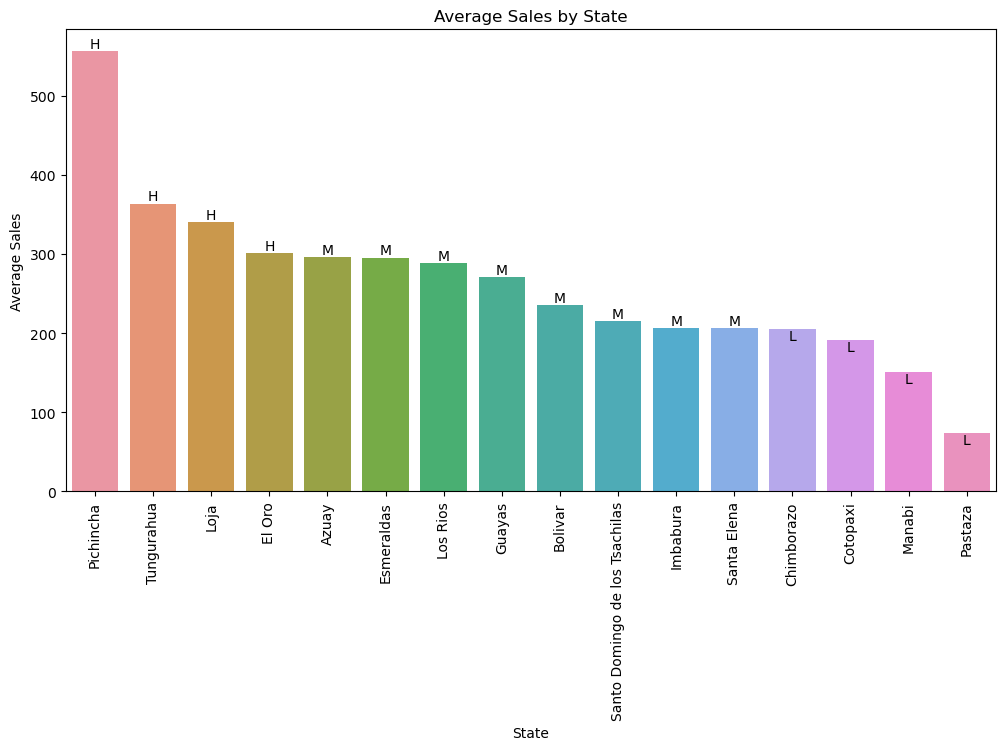

In [59]:
# Menghitung rata-rata penjualan untuk setiap negara bagian
sales_by_state = data.groupby('state')['sales'].mean().sort_values(ascending=False)

# Plot rata-rata penjualan per negara bagian
plt.figure(figsize=(12, 6))
sns.barplot(x=sales_by_state.index, y=sales_by_state.values)
plt.title('Average Sales by State')
plt.xlabel('State')
plt.ylabel('Average Sales')

# Menandai negara bagian dengan penjualan tinggi, sedang, dan rendah
high_threshold = sales_by_state.quantile(0.75)
low_threshold = sales_by_state.quantile(0.25)

for i, value in enumerate(sales_by_state):
    if value >= high_threshold:
        plt.text(i, value, 'H', ha='center', va='bottom')
    elif value <= low_threshold:
        plt.text(i, value, 'L', ha='center', va='top')
    else:
        plt.text(i, value, 'M', ha='center', va='bottom')

plt.xticks(rotation=90)
plt.show()

NOTE:

H = High sales, M = Medium sales, L = Low sales

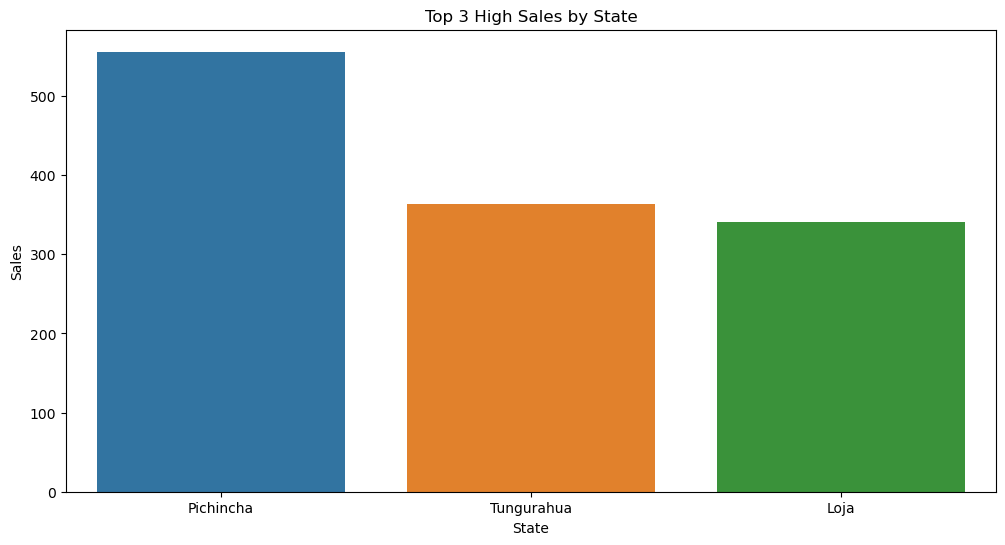

In [60]:
# High Sales tiap state
# Menghitung rata-rata penjualan untuk setiap negara bagian
sales_by_state = data.groupby('state')['sales'].mean().sort_values(ascending=False).head(3)

# Plot rata-rata penjualan per negara bagian
plt.figure(figsize=(12, 6))
sns.barplot(x=sales_by_state.index, y=sales_by_state.values)
plt.title('Top 3 High Sales by State')
plt.xlabel('State')
plt.ylabel('Sales')
plt.show()

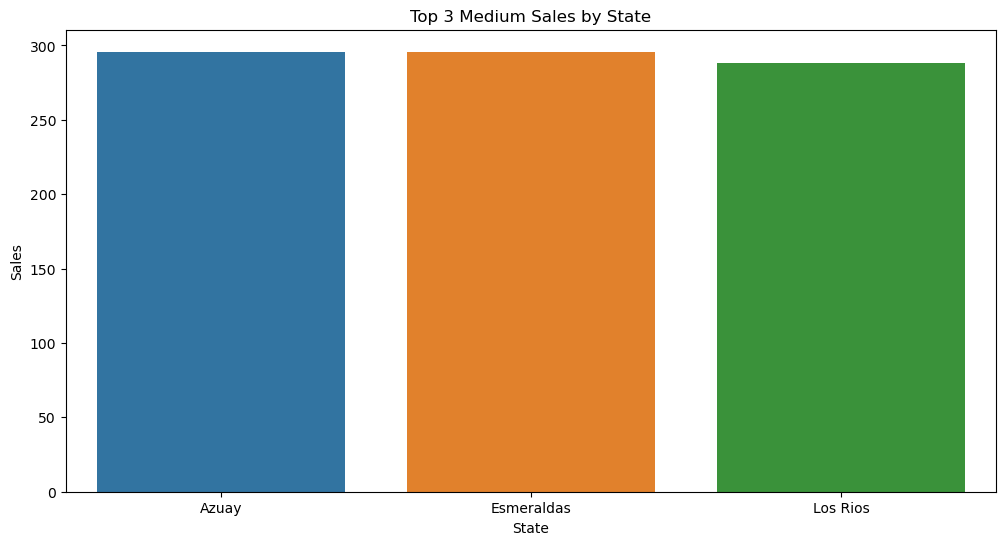

In [61]:
# Medium Sales tiap state
# Menghitung rata-rata penjualan untuk setiap negara bagian
sales_by_state = data.groupby('state')['sales'].mean().sort_values(ascending=False).iloc[4:7]

# Plot rata-rata penjualan per negara bagian
plt.figure(figsize=(12, 6))
sns.barplot(x=sales_by_state.index, y=sales_by_state.values)
plt.title('Top 3 Medium Sales by State')
plt.xlabel('State')
plt.ylabel('Sales')
plt.show()

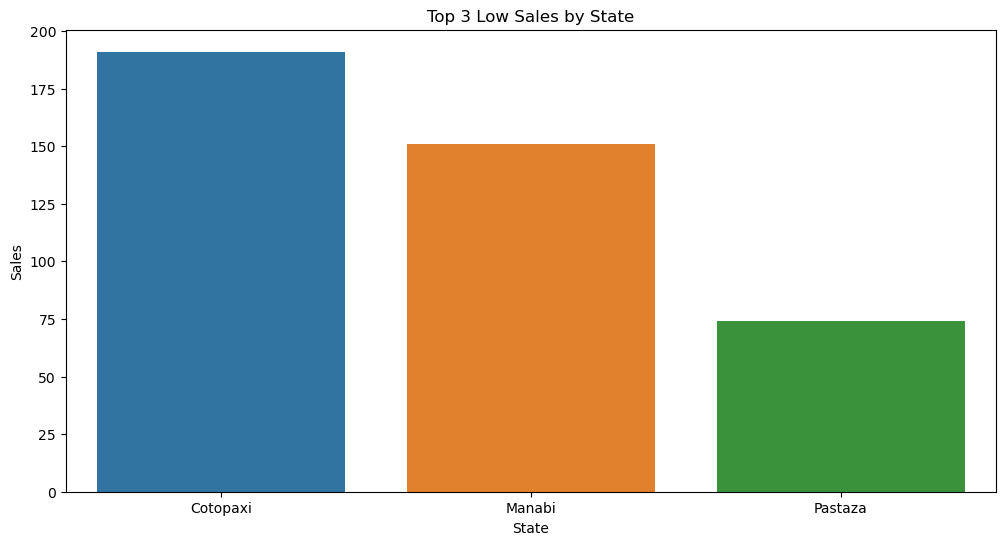

In [62]:
# High Sales tiap state
# Menghitung rata-rata penjualan untuk setiap negara bagian
sales_by_state = data.groupby('state')['sales'].mean().sort_values(ascending=False).tail(3)

# Plot rata-rata penjualan per negara bagian
plt.figure(figsize=(12, 6))
sns.barplot(x=sales_by_state.index, y=sales_by_state.values)
plt.title('Top 3 Low Sales by State')
plt.xlabel('State')
plt.ylabel('Sales')
plt.show()

# 9. Apakah ada perbedaan tren penjualan antara toko yang berbeda tipe atau cluster?

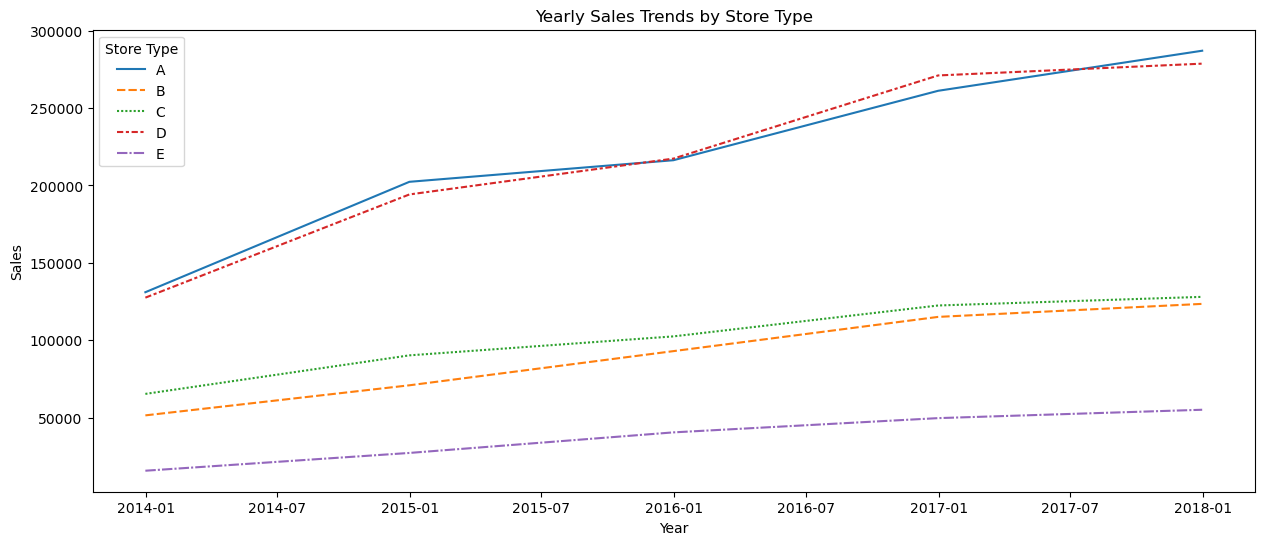

In [63]:
grouped_data = data.groupby(['store_type', 'date'], as_index=False).agg({'sales':'sum'})
pivoted_data = pd.pivot_table(grouped_data, values='sales', index='date', columns='store_type')
yearly_data = pivoted_data.resample('Y').mean()

plt.figure(figsize=(15, 6))
sns.lineplot(data=yearly_data)
plt.title('Yearly Sales Trends by Store Type')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend(title='Store Type')
plt.show()

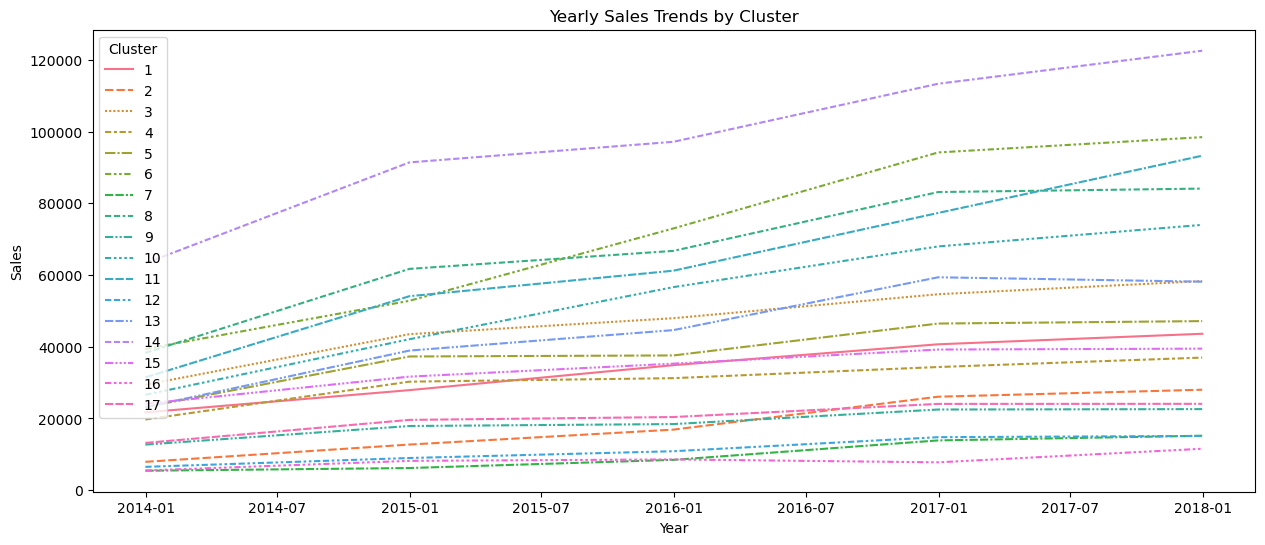

In [64]:
grouped_data = data.groupby(['cluster', 'date'], as_index=False).agg({'sales':'sum'})
pivoted_data = pd.pivot_table(grouped_data, values='sales', index='date', columns='cluster')
yearly_data = pivoted_data.resample('Y').mean()

plt.figure(figsize=(15, 6))
sns.lineplot(data=yearly_data)
plt.title('Yearly Sales Trends by Cluster')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend(title='Cluster')
plt.show()

# 10. Bagaimana tren penjualan pada saat payday yaitu tanggal 15 dan hari terakhir tiap bulan?

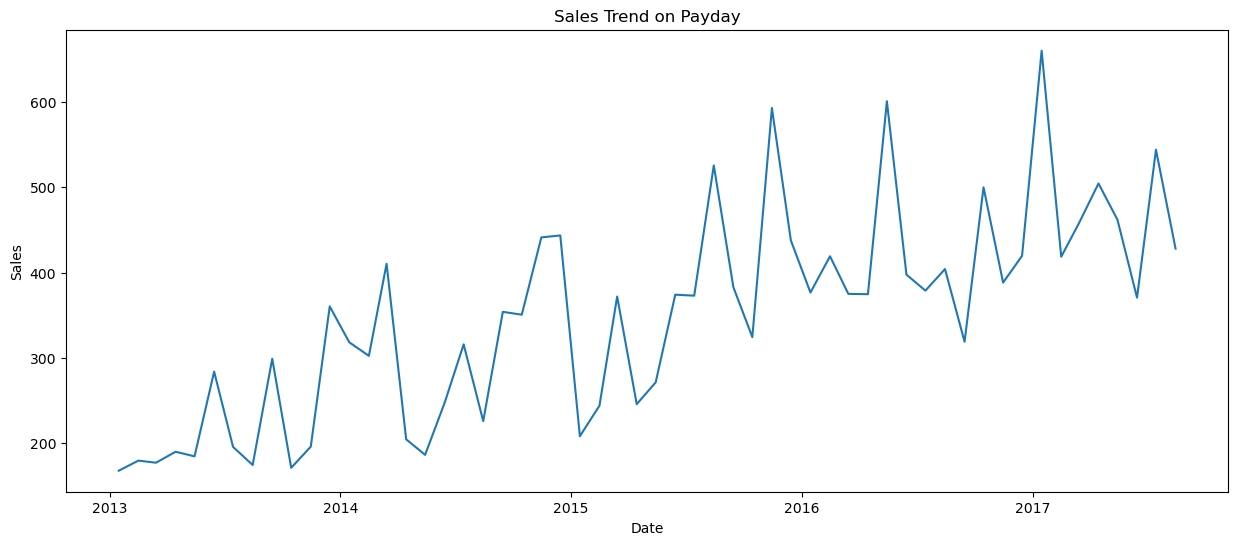

In [65]:
# konversi kolom date ke tipe datetime
data['date'] = pd.to_datetime(data['date'])

# identifikasi tanggal upah di sektor publik (15 dan hari terakhir setiap bulan)
public_paydays = [15, data['date'].dt.daysinmonth]

# buat kolom baru untuk menandai apakah tanggal adalah hari upah atau bukan
data['is_payday'] = data['date'].dt.day.isin(public_paydays)

# kelompokkan data berdasarkan tanggal dan is_payday, kemudian hitung rata-rata penjualan
sales_by_date = data.groupby(['date', 'is_payday'])['sales'].mean().reset_index()

# pisahkan data untuk hari upah dan hari-hari lainnya
payday_sales = sales_by_date[sales_by_date['is_payday'] == True]
non_payday_sales = sales_by_date[sales_by_date['is_payday'] == False]

# plot tren penjualan di hari upah
plt.figure(figsize=(15, 6)) 
plt.plot(payday_sales['date'], payday_sales['sales'], label='Payday')
plt.title('Sales Trend on Payday')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

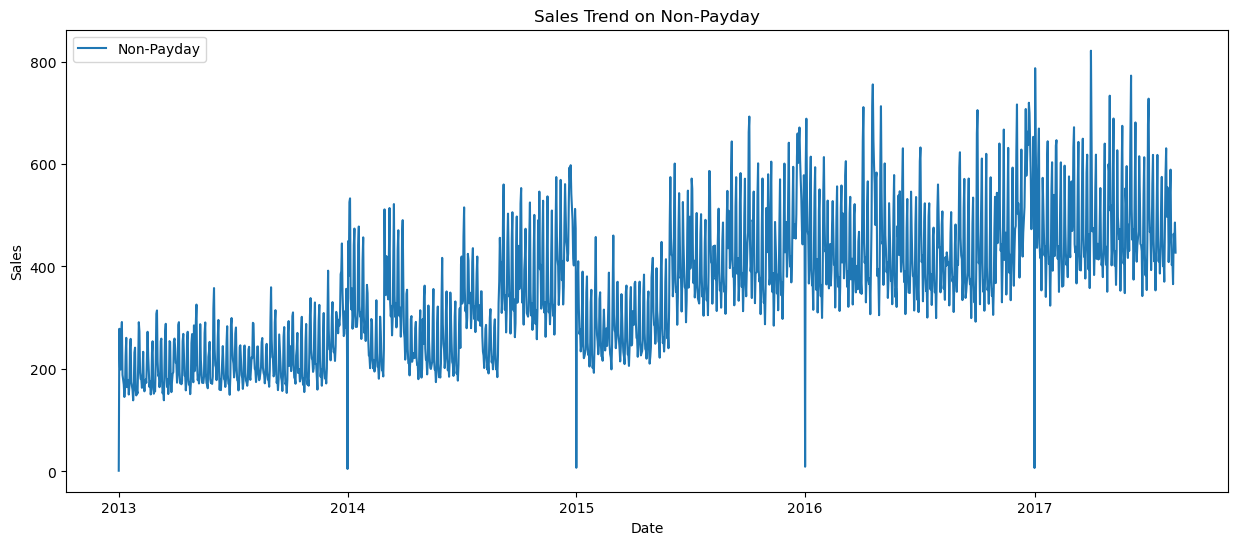

In [66]:
# plot tren penjualan non payday
plt.figure(figsize=(15, 6)) 
plt.plot(non_payday_sales['date'], non_payday_sales['sales'], label='Non-Payday')
plt.legend()
plt.title('Sales Trend on Non-Payday')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

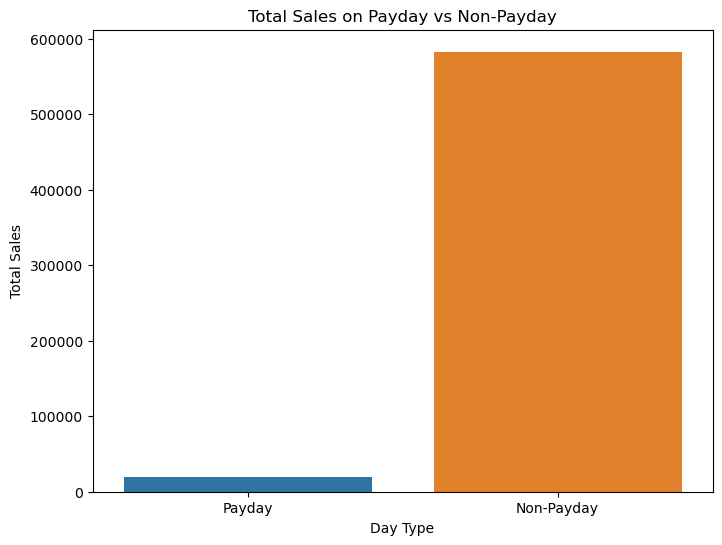

In [67]:
# Menghitung total penjualan saat payday dan non-payday
total_payday_sales = payday_sales['sales'].sum()
total_non_payday_sales = non_payday_sales['sales'].sum()

# Membuat DataFrame untuk perbandingan
comparison_data = pd.DataFrame({'Day Type': ['Payday', 'Non-Payday'],
                               'Total Sales': [total_payday_sales, total_non_payday_sales]})

# Membuat plot menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Day Type', y='Total Sales', data=comparison_data)
plt.title('Total Sales on Payday vs Non-Payday')
plt.xlabel('Day Type')
plt.ylabel('Total Sales')
plt.show()

# 11. Bagaimana penjualan berdasarkan store type dan store number ?

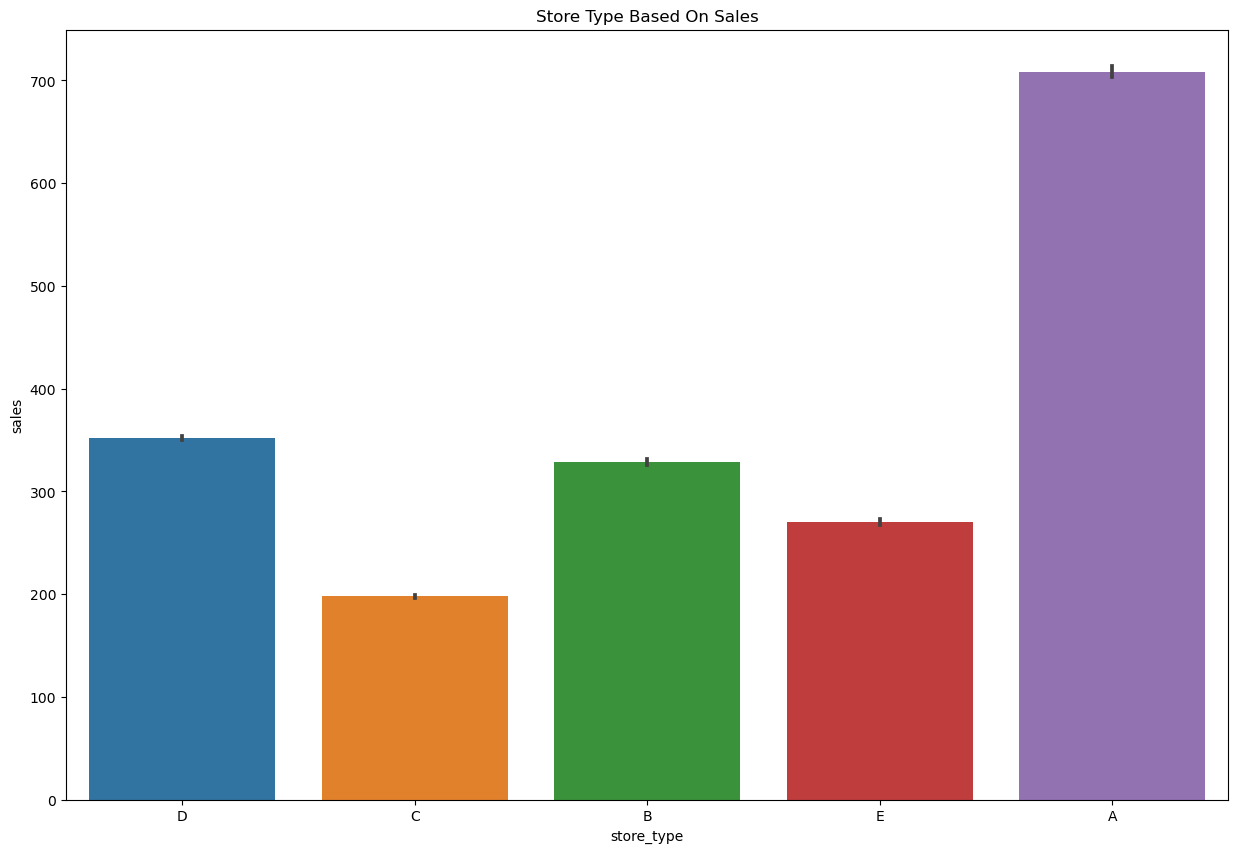

In [68]:
# Berdasarkan store type
plt.figure(figsize=(15,10))
sns.barplot(x="store_type", y="sales", data=data)
plt.title('Store Type Based On Sales')
plt.show()

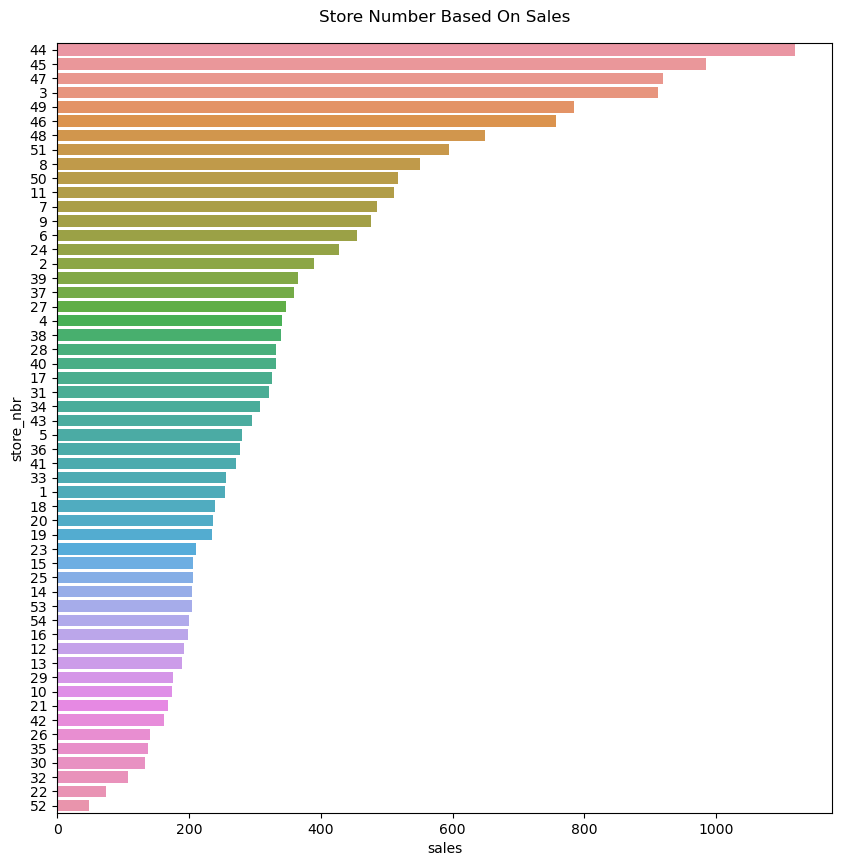

In [69]:
# Berdasarkan store number
store_sales = data.groupby("store_nbr").sales.mean().sort_values(ascending = False).reset_index()
store_sales['store_nbr'] = store_sales['store_nbr'].astype('category')
plt.figure(figsize=(10, 10))
sns.barplot(y='store_nbr', x='sales', data=store_sales, order=store_sales.sort_values('sales', ascending=False).store_nbr[0:54])
plt.title("Store Number Based On Sales", pad=15);

# 12. Bagaimana transaksi tiap store number?

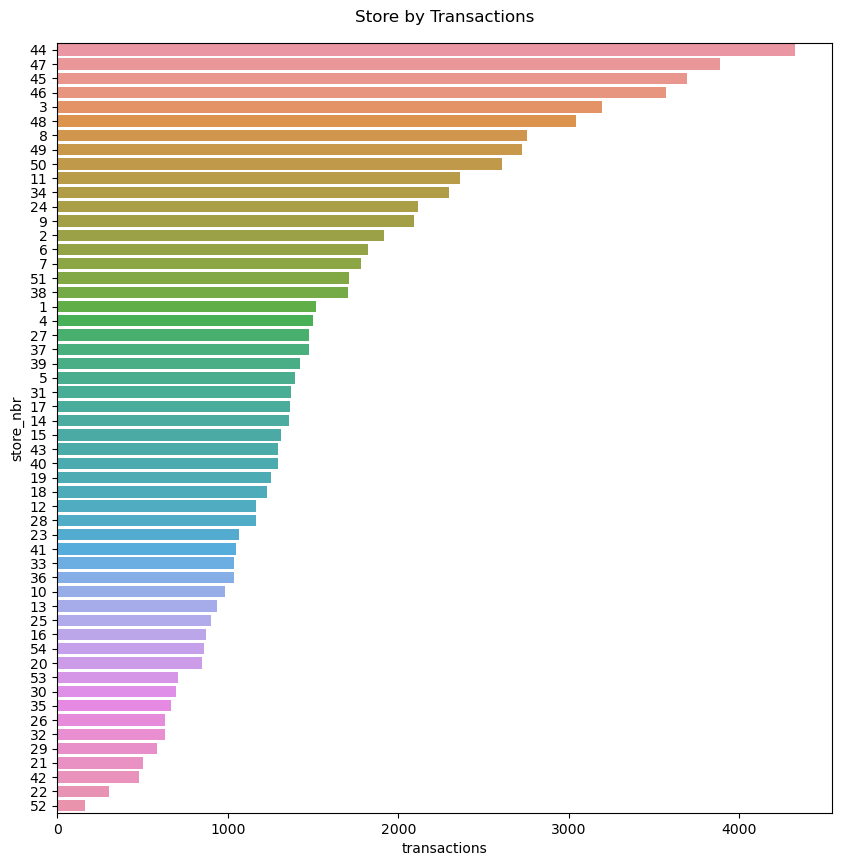

In [70]:
store_transactions = data.groupby("store_nbr").transactions.mean().sort_values(ascending = False).reset_index()
store_transactions['store_nbr'] = store_transactions['store_nbr'].astype('category')
plt.figure(figsize=(10, 10))
sns.barplot(y='store_nbr', x='transactions', data=store_transactions,
            order=store_transactions.sort_values('transactions', ascending=False).store_nbr[0:54])
plt.title("Store by Transactions", pad=15);

# 13. Toko-toko dan jenis produk yang masuk dalam 10 besar yang memiliki nilai penjualan tertinggi

In [71]:
sales_trans = store_sales[0:10]
print(sales_trans)

sales_family = product_sales[0:10]
print(sales_family)

  store_nbr        sales
0        44  1120.118405
1        45   984.565998
2        47   919.777871
3         3   911.098054
4        49   784.039156
5        46   756.775349
6        48   649.584599
7        51   594.106667
8         8   550.264615
9        50   517.551554
          family        sales
0      GROCERY I  3790.432797
1      BEVERAGES  2394.912701
2        PRODUCE  1355.373698
3       CLEANING  1074.171518
4          DAIRY   711.175991
5   BREAD/BAKERY   464.150612
6        POULTRY   351.078816
7          MEATS   341.965905
8  PERSONAL CARE   271.192381
9           DELI   265.629746


# Encode Data

In [72]:
#encode kolom categorical
storetype_values = {'A':1, 'D':4, 'B':3, 'E':5, 'C':3}
data['store_type'] = data.store_type.map(storetype_values)
#Encoding locale column 
locale_values = {'National':1, 'Regional':2, 'Local':3, 'Not Detected':4}
data['locale'] = data.locale.map(locale_values)
#Encoding Earthquake column 
Earthquake_values = {'Before Earthquake':1, 'After Earthquake':2}
data['Earthquake'] = data.Earthquake.map(Earthquake_values)
#Encoding type_holiday column 
typeholiday_values = {'Holiday':1, 'Not Holiday':2}
data['type_holiday'] = data.type_holiday.map(typeholiday_values)

In [73]:
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
data['family_encode'] = labelencoder.fit_transform(data['family'])
data['city_encode'] = labelencoder.fit_transform(data['city'])
data['state_encode'] = labelencoder.fit_transform(data['state'])
data['locale_name_encode'] = labelencoder.fit_transform(data['locale_name'])
data['desc_encode'] = labelencoder.fit_transform(data['desc'])

In [74]:
data.head()

,id,date,store_nbr,family,sales,onpromotion,locale,locale_name,transferred,dcoilwtico,...,Month,Year,week,year,is_payday,family_encode,city_encode,state_encode,locale_name_encode,desc_encode
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,Ecuador,False,68.015874,...,1,2013,1,2013,False,0,18,12,4,9
1,1,2013-01-01,1,BABY CARE,0.0,0,1,Ecuador,False,68.015874,...,1,2013,1,2013,False,1,18,12,4,9
2,2,2013-01-01,1,BEAUTY,0.0,0,1,Ecuador,False,68.015874,...,1,2013,1,2013,False,2,18,12,4,9
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,Ecuador,False,68.015874,...,1,2013,1,2013,False,3,18,12,4,9
4,4,2013-01-01,1,BOOKS,0.0,0,1,Ecuador,False,68.015874,...,1,2013,1,2013,False,4,18,12,4,9


In [75]:
data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'locale',
       'locale_name', 'transferred', 'dcoilwtico', 'city', 'state',
       'store_type', 'cluster', 'transactions', 'type_holiday', 'desc',
       'total_sales', 'Earthquake', 'Month', 'Year', 'week', 'year',
       'is_payday', 'family_encode', 'city_encode', 'state_encode',
       'locale_name_encode', 'desc_encode'],
      dtype='object')

# Korelasi data

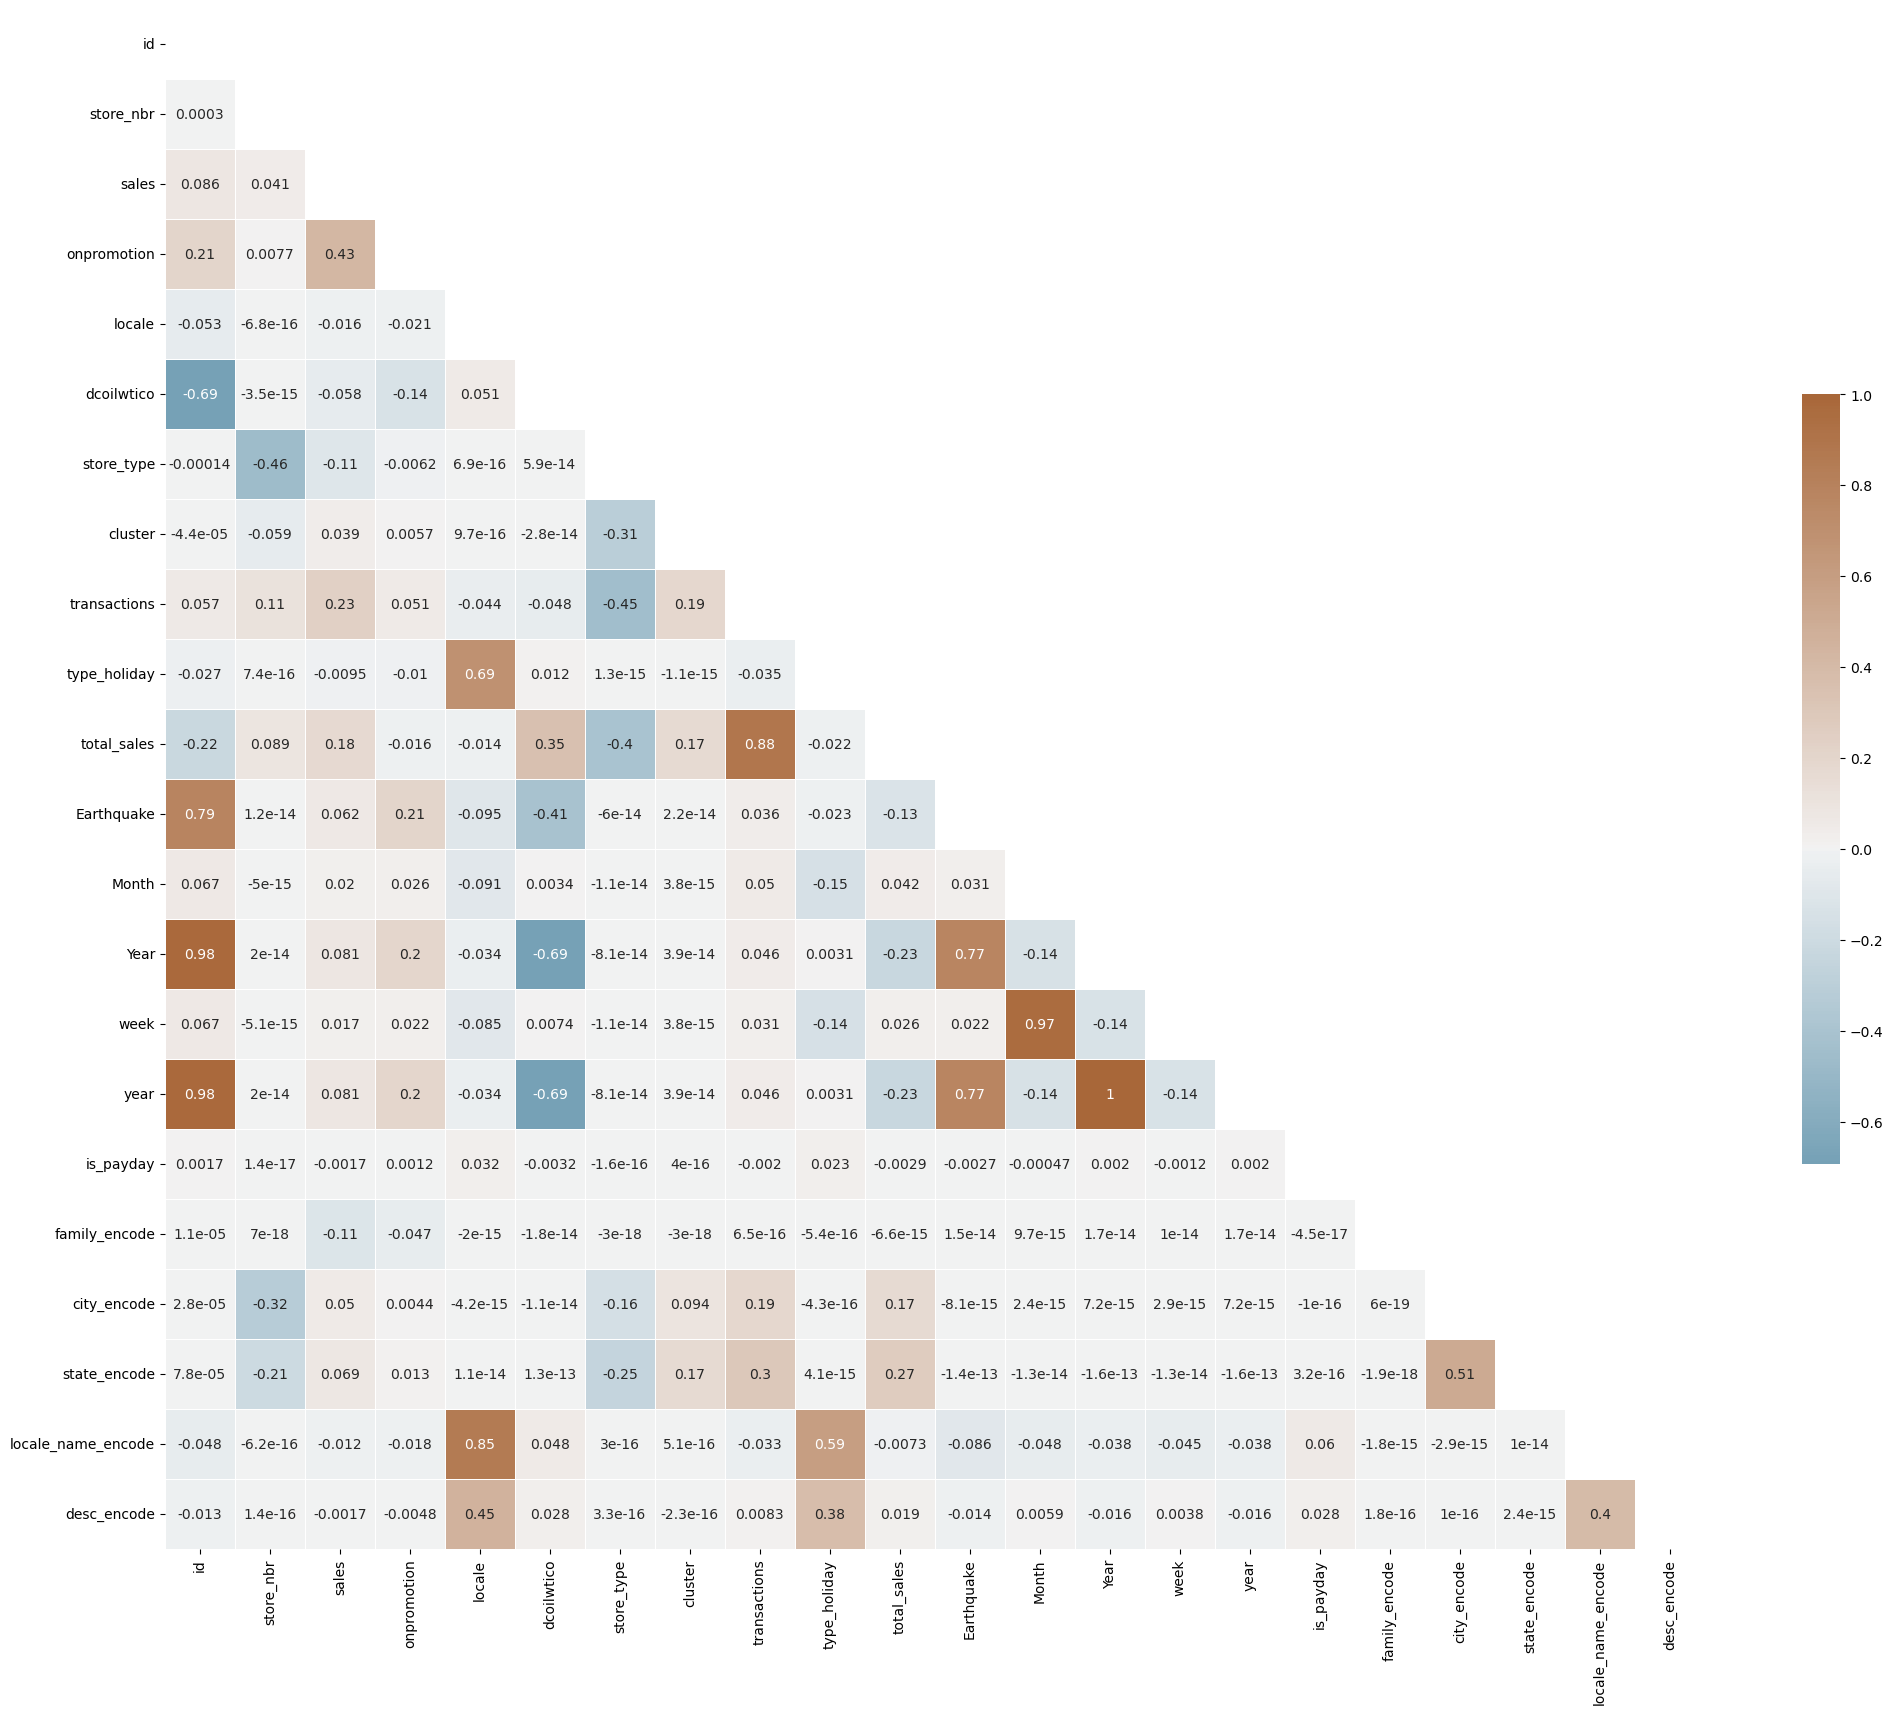

In [76]:
# Correlation Heatmap

f, ax = plt.subplots(figsize=(25, 20))
mat = data.corr()
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 35, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [77]:
data.shape

(3054348, 29)

In [78]:
# drop kolom yang tidak terpakai
data = data.drop(columns=['dcoilwtico','total_sales','transferred'])
data.head()

,id,date,store_nbr,family,sales,onpromotion,locale,locale_name,city,state,...,Month,Year,week,year,is_payday,family_encode,city_encode,state_encode,locale_name_encode,desc_encode
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,Ecuador,Quito,Pichincha,...,1,2013,1,2013,False,0,18,12,4,9
1,1,2013-01-01,1,BABY CARE,0.0,0,1,Ecuador,Quito,Pichincha,...,1,2013,1,2013,False,1,18,12,4,9
2,2,2013-01-01,1,BEAUTY,0.0,0,1,Ecuador,Quito,Pichincha,...,1,2013,1,2013,False,2,18,12,4,9
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,Ecuador,Quito,Pichincha,...,1,2013,1,2013,False,3,18,12,4,9
4,4,2013-01-01,1,BOOKS,0.0,0,1,Ecuador,Quito,Pichincha,...,1,2013,1,2013,False,4,18,12,4,9


In [79]:
data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'locale',
       'locale_name', 'city', 'state', 'store_type', 'cluster', 'transactions',
       'type_holiday', 'desc', 'Earthquake', 'Month', 'Year', 'week', 'year',
       'is_payday', 'family_encode', 'city_encode', 'state_encode',
       'locale_name_encode', 'desc_encode'],
      dtype='object')

# Splitting data dan scalling 

In [80]:
# Membuat model_features yang akan digunakan untuk modelling
model_features = ['store_nbr','onpromotion','locale','store_type',
                  'cluster','transactions','type_holiday','Earthquake',
                  'Month','Year','week','family_encode','city_encode',
                  'state_encode','locale_name_encode','desc_encode']

In [81]:
Y = data['sales']
X = data[model_features]
test_size = .2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state = 1)

In [82]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [83]:
# Membuat data frame
X_train_scaled1 = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled1 = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Modelling

In [84]:
# XGB Model
xgb = XGBRegressor(random_state=1)
xgb.fit(X_train_scaled1, y_train)
prediction_xgb = xgb.predict(X_test_scaled1)
print('RMSE = ', mean_squared_error(y_test, prediction_xgb, squared = False))
print('MAE = ', mean_absolute_error(y_test, prediction_xgb))
print('R2 Score = ', r2_score(y_test, prediction_xgb))

RMSE =  295.029115478515
MAE =  98.79064069229216
R2 Score =  0.9287557677715413


In [85]:
# Decision Tree Model
dtr = DecisionTreeRegressor(random_state=1)
dtr.fit(X_train_scaled1, y_train)
prediction_dtr = dtr.predict(X_test_scaled1)
print('RMSE = ', mean_squared_error(y_test, prediction_dtr, squared = False))
print('MAE = ', mean_absolute_error(y_test, prediction_dtr))
print('R2 Score = ', r2_score(y_test, prediction_dtr))

RMSE =  364.46431734280884
MAE =  65.28420310734765
R2 Score =  0.8912748571467762


In [86]:
# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train_scaled1, y_train)
prediction_lr = lr.predict(X_test_scaled1)
print('RMSE = ', mean_squared_error(y_test, prediction_lr, squared = False))
print('MAE = ', mean_absolute_error(y_test, prediction_lr))
print('R2 Score = ', r2_score(y_test, prediction_lr))

RMSE =  964.7221940796323
MAE =  421.8025207588711
R2 Score =  0.23822889387495172


# Feature Importance

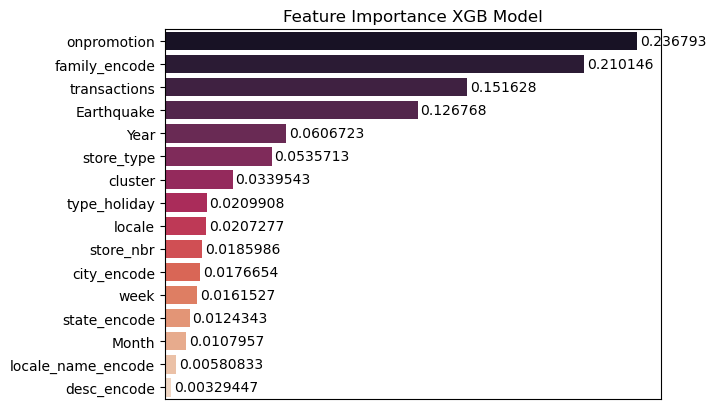

In [87]:
# XGB Model
features_xgb = pd.DataFrame({'features': xgb.feature_names_in_, 'importances': xgb.feature_importances_})
features_xgb_sorted = features_xgb.sort_values(by='importances', ascending=False)
sns.despine(bottom=True, left=True)
xgb_fi = sns.barplot(data=features_xgb_sorted, x='importances', y='features', palette='rocket')
xgb_fi.set_title('Feature Importance XGB Model')
xgb_fi.set(xlabel=None, ylabel=None, xticks=[])
for value in xgb_fi.containers:
    xgb_fi.bar_label(value, padding=2)

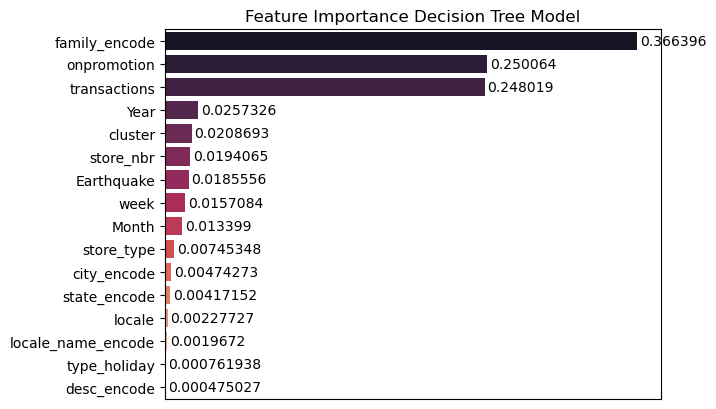

In [88]:
# Decision Tree Model
features_dtr = pd.DataFrame({'features': dtr.feature_names_in_, 'importances': dtr.feature_importances_})
features_dtr_sorted = features_dtr.sort_values(by='importances', ascending=False)
sns.despine(bottom=True, left=True)
dtr_fi = sns.barplot(data=features_dtr_sorted, x='importances', y='features', palette='rocket')
dtr_fi.set_title('Feature Importance Decision Tree Model')
dtr_fi.set(xlabel=None, ylabel=None, xticks=[])
for value in dtr_fi.containers:
    dtr_fi.bar_label(value, padding=2)

Feature:0, Score: 74.85402
Feature:1, Score: 27957.46019
Feature:2, Score: -26.40952
Feature:3, Score: 5.46543
Feature:4, Score: -11.26559
Feature:5, Score: 1863.40682
Feature:6, Score: 18.74976
Feature:7, Score: -143.83147
Feature:8, Score: -40.00309
Feature:9, Score: 116.09866
Feature:10, Score: 68.89740
Feature:11, Score: -349.56494
Feature:12, Score: 59.17669
Feature:13, Score: -8.90862
Feature:14, Score: 12.13902
Feature:15, Score: -15.17231


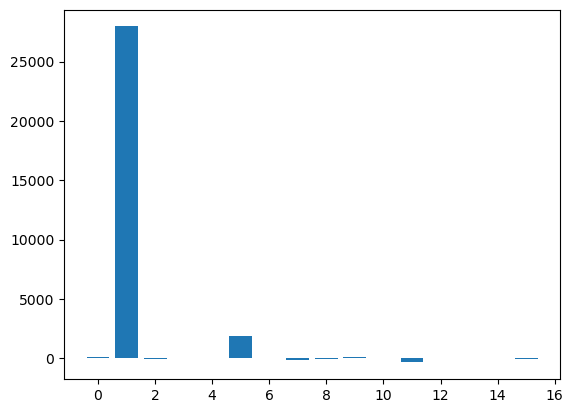

In [89]:
# Linear Regression Model
importance = lr.coef_
for i, v in enumerate(importance):
    print('Feature:%0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# Hyperparameter Tuning

## XGB

In [90]:
params = {
    'n_estimators':[2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_depth':[10, 15, 20, 25, 30, 35, 40],
    'max_leaves':[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
    'learning_rate':[0.05, 0.1, 0.15, 0.2],
    'booster':["gbtree", "gblinear", "dart"]
}

In [91]:
rs_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=params, n_iter=5, cv= 3, random_state=1)
rs_xgb.fit(X_train_scaled1, y_train)
print(rs_xgb.best_params_)

[22:57:11] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.

[22:57:13] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.

[22:57:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.

{'n_estimators': 8, 'max_leaves': 16, 'max_depth': 15, 'learning_rate': 0.2, 'booster': 'gbtree'}


### Model XGB dengan hasil tuning

In [92]:
xgb1 = XGBRegressor(n_estimators=8, max_leaves=16, max_depth=15, learning_rate=0.2, booster='gbtree', random_state=1)
xgb1.fit(X_train_scaled1, y_train)
prediction_xgb1 = xgb1.predict(X_test_scaled1)
print('RMSE = ', mean_squared_error(y_test, prediction_xgb1, squared = False))
print('MAE = ', mean_absolute_error(y_test, prediction_xgb1))
print('R2 Score = ', r2_score(y_test, prediction_xgb1))

RMSE =  319.3801459764735
MAE =  77.48260275605396
R2 Score =  0.9165097452363922


## Decision Tree

In [93]:
# Decision Tree Model
params_dtr = {
    'criterion':["squared_error", "friedman_mse"],
    'splitter':["best", "random"],
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_features': ['auto', 'sqrt']
}

In [94]:
rs_dtr = RandomizedSearchCV(estimator=dtr, param_distributions=params_dtr, n_iter=5, cv= 3, random_state=1)
rs_dtr.fit(X_train_scaled1, y_train)
print(rs_dtr.best_params_)

{'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 25, 'criterion': 'squared_error'}


### Model Decision Tree dengan hasil tuning

In [95]:
dtr1 = DecisionTreeRegressor(splitter='best', min_samples_split=10, min_samples_leaf=1, max_features='auto',
                             max_depth=25, criterion='squared_error', random_state=1)
dtr1.fit(X_train_scaled1, y_train)
prediction_dtr1 = dtr1.predict(X_test_scaled1)
print('RMSE = ', mean_squared_error(y_test, prediction_dtr1, squared = False))
print('MAE = ', mean_absolute_error(y_test, prediction_dtr1))
print('R2 Score = ', r2_score(y_test, prediction_dtr1))

RMSE =  277.0705557093708
MAE =  58.32761807207905
R2 Score =  0.937165131914245


# Buat dataframe berisi gabungan hasil prediction, store_nbr, family

In [96]:
dfpredict = pd.DataFrame()
dfpredict.head()

""


In [97]:
dfpredict['store_nbr'] = X_train['store_nbr']
dfpredict['family_encode'] = X_train['family_encode']
dfpredict['Month'] = X_train['Month']
dfpredict['prediction'] = pd.DataFrame(prediction_dtr1)
dfpredict.tail(n = 5)

,store_nbr,family_encode,Month,prediction
836489,3,5,4,NaN
491263,42,25,9,28.071429
2568076,15,16,11,NaN
491755,7,22,9,410.888889
128037,50,30,3,13.524500


drop baris yang masih ada value NaN

In [98]:
#drop NaN di dataframe
dfpred = dfpredict.dropna(axis = 0, how ='any')
dfpred.head()

,store_nbr,family_encode,Month,prediction
23044,6,10,1,15.873016
586276,9,31,11,0.000000
86796,44,6,2,158.272667
503419,34,4,10,155.333333
114266,15,20,3,76.800000


In [99]:
#melihat informasi family yang telah di-encode
data[['family','family_encode']].head(n = 33)

,family,family_encode
0,AUTOMOTIVE,0
1,BABY CARE,1
2,BEAUTY,2
3,BEVERAGES,3
4,BOOKS,4
5,BREAD/BAKERY,5
6,CELEBRATION,6
7,CLEANING,7
8,DAIRY,8
9,DELI,9


In [100]:
family_name = {0:'AUTOMOTIVE', 1:'BABY CARE', 2:'BEAUTY', 3:'BEVERAGES', 4:'BOOKS', 5:'BREAD/BAKERY', 6:'CELEBRATION',
                   7:'CLEANING', 8:'DAIRY', 9:'DELI', 10:'EGGS', 11:'FROZEN FOODS', 12:'GROCERY I', 13:'GROCERY II', 14:'HARDWARE',
                   15:'HOME AND KITCHEN I', 16:'HOME AND KITCHEN II', 17:'HOME APPLIANCES', 18:'HOME CARE', 19:'LADIESWEAR', 
                   20:'LAWN AND GARDEN', 21:'LINGERIE', 22:'LIQUOR,WINE,BEER', 23:'MAGAZINES', 24:'MEATS', 25:'PERSONAL CARE', 
                   26:'PET SUPPLIES', 27:'PLAYERS AND ELECTRONICS', 28:'POULTRY', 29:'PREPARED FOODS', 30:'PRODUCE', 31:'SCHOOL AND OFFICE SUPPLIES',
                   32:'SEAFOOD'}
dfpred['family_encode'] = dfpred.family_encode.map(family_name)

In [101]:
dfpred

,store_nbr,family_encode,Month,prediction
23044,6,EGGS,1,15.873016
586276,9,SCHOOL AND OFFICE SUPPLIES,11,0.000000
86796,44,CELEBRATION,2,158.272667
503419,34,BOOKS,10,155.333333
114266,15,LAWN AND GARDEN,3,76.800000
...,...,...,...,...
413825,20,BREAD/BAKERY,8,0.000000
73349,17,MAGAZINES,2,2.714286
491263,42,PERSONAL CARE,9,28.071429
491755,7,"LIQUOR,WINE,BEER",9,410.888889


In [102]:
dfpred = dfpred.drop(dfpred.index[dfpred['prediction'] < 0])

In [104]:
#melakukan grouping data sesuai tanggal, store number dan family
df_f1 = dfpred.groupby(["family_encode","store_nbr",'Month']).agg(np.mean) 
df_f1

prediction
family_encode store_nbr Month            
AUTOMOTIVE    1         1      272.278299
                        2       75.755068
                        3      300.464287
                        4      120.382899
                        5      411.768414
...                                   ...
SEAFOOD       54        8      421.309261
                        9      234.113616
                        10     658.974141
                        11     175.448084
                        12      11.648423

[21383 rows x 1 columns]

In [105]:
# cek apakah terdapat missing value di data prediksi
df_f1.isnull().sum()

prediction    0
dtype: int64

In [108]:
grouped_data = dfpred.groupby(['family_encode','store_nbr','Month'])
sales_by_date = grouped_data['prediction'].sum()

highest_sales = pd.DataFrame(sales_by_date.groupby('Month').nlargest(1))
lowest_sales = pd.DataFrame(sales_by_date.groupby('Month').nsmallest(1))

In [109]:
highest_sales

,,,,prediction
Month,family_encode,store_nbr,Month,
1,LINGERIE,43,1,36593.618503
2,BREAD/BAKERY,52,2,38546.710611
3,POULTRY,22,3,38579.913651
4,PREPARED FOODS,22,4,36342.908142
5,LADIESWEAR,6,5,43796.856579
6,PET SUPPLIES,26,6,32991.823607
7,POULTRY,10,7,37702.028504
8,EGGS,41,8,39510.028743
9,DAIRY,34,9,46080.761723


In [110]:
lowest_sales

,,,,prediction
Month,family_encode,store_nbr,Month,
1,AUTOMOTIVE,32,1,450.746190
2,HOME AND KITCHEN II,21,2,301.461926
3,PET SUPPLIES,49,3,333.365723
4,BABY CARE,48,4,576.270232
5,BEVERAGES,44,5,531.227055
6,BOOKS,37,6,870.782863
7,BREAD/BAKERY,6,7,578.705316
8,SCHOOL AND OFFICE SUPPLIES,28,8,657.854878
9,"LIQUOR,WINE,BEER",37,9,294.047301


In [113]:
import pickle
dfpred_pickle = dfpred.to_pickle('C:/STUDI INDEPENDEN/Startup Campus/Final Project/dfpred_pickle.pickle')

In [114]:
import pickle
df_f1_pickle = df_f1.to_pickle('C:/STUDI INDEPENDEN/Startup Campus/Final Project/df_f1_pickle.pickle')